<a href="https://colab.research.google.com/github/tatiana-ka/movie-plot-text-clustering-topic-modeling/blob/main/movies2012_1985_2005_2011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<u>This is work in progress </u>. 
Introduction, motivation behind the project, its goal, approach and meaning of the results will follow. 

In [ ]:
from google.colab import files, drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import re
import ast
import spacy
import nltk
import scipy.stats

### **Initial Data Prep**

**1. Loading Meta Data**

In [ ]:
meta = pd.read_csv('/content/drive/MyDrive/movies2012data/movie.metadata.tsv', sep = '\t', header = None)

meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

0. Wikipedia movie ID
1. Freebase movie ID
2. Movie name
3. Movie release date
4. Movie box office revenue
5. Movie runtime
6. Movie languages (Freebase ID:name tuples)
7. Movie countries (Freebase ID:name tuples)
8. Movie genres (Freebase ID:name tuples)

In [ ]:
meta = meta.rename(columns= {0: 'wiki_movieID',
                             2: 'movie_name',
                             3: 'release_date',
                             4: 'box_of_rev',
                             5: 'run_time',
                             6: 'languages',
                             7: 'countries',
                             8: 'genres'}) #rename columns

In [ ]:
meta = meta.drop(columns=1) # drop FreebaseID

In [ ]:
meta.head()

,wiki_movieID,movie_name,release_date,box_of_rev,run_time,languages,countries,genres
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


**2. Loading Plots**

In [ ]:
plot = pd.read_csv('/content/drive/MyDrive/movies2012data/plot_summaries.txt', delimiter= '\t', header = None)

plot.head()

,0,1
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Plot summaries of 42,303 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [ ]:
plot = plot.rename(columns={0:'wiki_movieID', 
                            1: 'summary'}) #renaming columns

**3. Merging the two dfs**

In [ ]:
merged = plot.merge(meta, on = 'wiki_movieID', how = 'left')

In [ ]:
merged.head()

,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


**4. Saving**

In [ ]:
merged.to_csv('merged_movies_df.csv')

!cp merged_movies_df.csv "/content/drive/MyDrive/movies2012data"

##### **5. A bit of random exploration**

In [ ]:
len(merged)

42303

In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42303 entries, 0 to 42302
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wiki_movieID  42303 non-null  int64  
 1   summary       42303 non-null  object 
 2   movie_name    42204 non-null  object 
 3   release_date  39586 non-null  object 
 4   box_of_rev    7587 non-null   float64
 5   run_time      35580 non-null  float64
 6   languages     42204 non-null  object 
 7   countries     42204 non-null  object 
 8   genres        42204 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.2+ MB


In [ ]:
merged.describe()

,wiki_movieID,box_of_rev,run_time
count,4.230300e+04,7.587000e+03,3.558000e+04
mean,1.497051e+07,5.175973e+07,1.285403e+02
std,1.111994e+07,1.167179e+08,5.721460e+03
min,3.300000e+02,1.020000e+04,3.000000e-01
25%,4.565802e+06,2.500000e+06,8.600000e+01
50%,1.284591e+07,1.242118e+07,9.600000e+01
75%,2.485168e+07,4.559722e+07,1.100000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [ ]:
columns = merged.columns

missing_count = []

for col in columns:
  missing_count.append(merged[col].isna().sum())

missing_summary = pd.DataFrame({'columns': columns,
                                'missing_coumnt': missing_count})

missing_summary  

,columns,missing_coumnt
0,wiki_movieID,0
1,summary,0
2,movie_name,99
3,release_date,2717
4,box_of_rev,34716
5,run_time,6723
6,languages,99
7,countries,99
8,genres,99


In [ ]:
merged.summary[0]

"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."

In [ ]:
len(merged.summary[0])

178

In [ ]:
summary_length = []

for i in range(len(merged)):
  summary_length.append(len(merged.summary[i]))


In [ ]:
summary_length = np.array(summary_length)


In [ ]:
np.mean(summary_length)

1784.0342292508806

In [ ]:
np.where(summary_length == 2000)

(array([27424, 28127, 31782, 40133]),)

In [ ]:
merged.summary[27424]

'The film begins with a replacement, Pilot Officer T. B. "Septic" Baird , landing his Hawker Hurricane at "Pimpernel" Squadron\'s airfield. Just as he touches down however, a straggler from an earlier mission taxis across his path. Septic\'s quick reactions allow him to "leapfrog" the other Hurricane, averting a costly disaster. However, this causes him to crash his replacement plane into the bungalow of Squadron Leader Barry Clinton  at the end of the runway. This earns Septic the wrath of his new squadron leader, Bill Ponsford , because he damaged his plane. The crash also injures the ligaments in Septic\'s neck, which he is able to self diagnose, as he had been a medical student before the war. The next morning, Septic is told by Group Captain "Tiger" Small  that he will not be able to fly until his neck is healed, so he will instead serve in the operations room for the time being. Several days later, with the risk of a bombing attack on the airfield, and all of Pimpernel Squadron\'

In [ ]:
np.max(summary_length)

28159

In [ ]:
np.where(summary_length == 28159)

(array([8888]),)

In [ ]:
merged.summary[8888]

' The Big Beginning starts with Timmy wishing he was in his own movie trilogy . In the first movie, he is chased by Crocker while they both have special powers. Then, he wishes he had a second movie, where he simply throws a ring into a volcano. In the third movie, he becomes "Timmy Totter" playing "Poofer Scoop" as he chases Poof around, until Vicky appears as "Moldy Wart" and chases him, which is then interrupted by Jorgen. He zaps away Timmy\'s fairies, before cryptically warning him to stick to the shadows and not to speak his name. Timmy then falls from the sky and lands in front of his house. Timmy claims was just like any one of his other normal mornings and walks inside his house. However, his parents don\'t seem to know who he is, thinking him a street urchin. When Timmy goes to school, everyone thinks that he\'s a new kid. Growing more and more confused, Timmy shouts his name through a megaphone. At that instant, an Eliminator  bursts into the class. Timmy manages to outrun t

### **Data Cleaning**

In [ ]:
movie1 = pd.read_csv('/content/drive/MyDrive/movies2012data/merged_movies_df.csv')

movie1.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres
0,0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


#### **1. Explore the Key variable (DV) - Box Office**

In [ ]:
movie1.box_of_rev.isna().sum()

34716

In [ ]:
len(movie1)

42303

In [ ]:
movie1.box_of_rev.isna().sum()/len(movie1)

0.8206510176583222

In [ ]:
len(movie1)-movie1.box_of_rev.isna().sum()

7587

Only 18% of data (7587 movies) have box office info. Will keep only those

In [ ]:
movie2 = movie1[movie1.box_of_rev.notna()]

In [ ]:
movie2.describe()

,Unnamed: 0,wiki_movieID,box_of_rev,run_time
count,7587.000000,7.587000e+03,7.587000e+03,7513.000000
mean,21350.236853,8.622736e+06,5.175973e+07,106.030574
std,12125.625067,9.949717e+06,1.167179e+08,22.785962
min,1.000000,3.217000e+03,1.020000e+04,10.000000
25%,11054.000000,1.134646e+06,2.500000e+06,93.000000
50%,21472.000000,3.723947e+06,1.242118e+07,103.000000
75%,31751.000000,1.393558e+07,4.559722e+07,115.000000
max,42296.000000,3.695679e+07,2.782275e+09,1003.000000


In [ ]:
movie2.box_of_rev.max()

2782275172.0

In [ ]:
movie2.box_of_rev.min()

10200.0

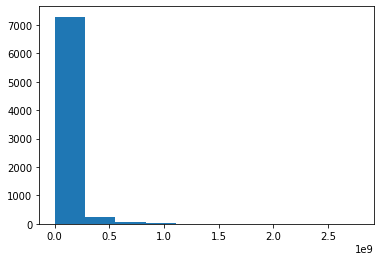

In [ ]:
plt.hist(movie2.box_of_rev)
plt.show()

In [ ]:
movie2.box_of_rev.quantile(0.5)

12421181.0

In [ ]:
movie2.box_of_rev.quantile(0.25)

2500000.0

In [ ]:
movie2.box_of_rev.quantile(0.75)

45597223.0

(array([2529.,  807.,  581.,  448.,  358.,  243.,  220.,  194.,  172.,
         138.]),
 array([1.02000000e+04, 4.56758360e+06, 9.12496720e+06, 1.36823508e+07,
        1.82397344e+07, 2.27971180e+07, 2.73545016e+07, 3.19118852e+07,
        3.64692688e+07, 4.10266524e+07, 4.55840360e+07]),
 <a list of 10 Patch objects>)

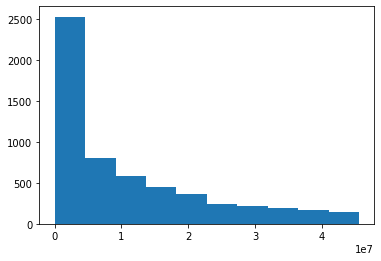

In [ ]:
plt.hist(movie2[movie2.box_of_rev <= movie2.box_of_rev.quantile(0.75)].box_of_rev)

(array([1197.,  679.,  435.,  307.,  251.,  228.,  183.,  154.,  197.,
         163.]),
 array([1.02000000e+04, 1.25129810e+06, 2.49239620e+06, 3.73349430e+06,
        4.97459240e+06, 6.21569050e+06, 7.45678860e+06, 8.69788670e+06,
        9.93898480e+06, 1.11800829e+07, 1.24211810e+07]),
 <a list of 10 Patch objects>)

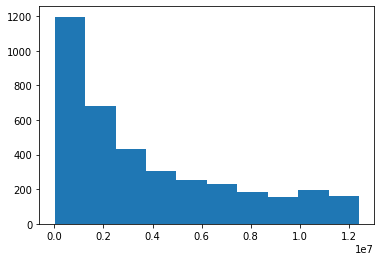

In [ ]:
plt.hist(movie2[movie2.box_of_rev <= movie2.box_of_rev.quantile(0.50)].box_of_rev)

(array([ 111.,  193.,  299.,  767., 1331., 1702., 1686., 1101.,  362.,
          35.]),
 array([ 9.230143  , 10.48178218, 11.73342137, 12.98506055, 14.23669973,
        15.48833892, 16.7399781 , 17.99161729, 19.24325647, 20.49489565,
        21.74653484]),
 <a list of 10 Patch objects>)

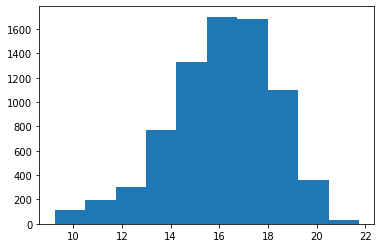

In [ ]:
plt.hist(np.log(movie2.box_of_rev)) # turns into a desent distribution with log trasformation

**2. Exploring the rest of the variables**

Exploration for further decitions about the data preparation

In [ ]:
movie2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7587 entries, 1 to 42296
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    7587 non-null   int64  
 1   wiki_movieID  7587 non-null   int64  
 2   summary       7587 non-null   object 
 3   movie_name    7587 non-null   object 
 4   release_date  7530 non-null   object 
 5   box_of_rev    7587 non-null   float64
 6   run_time      7513 non-null   float64
 7   languages     7587 non-null   object 
 8   countries     7587 non-null   object 
 9   genres        7587 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 652.0+ KB


Some missing values in *Release Date* and *Run Time*.
For simplisicty will drop all NAs for now. Can rerun the analysis including these movie plots larer on. 

In [ ]:
movie3 = movie2.dropna(axis = 0).copy().reset_index(drop = True)

In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama..."
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}"


#### **3. Reformating data into more informative variables**

Need to extract information from *Languages, Coutries, Genres*

##### Language

In [ ]:
movie3['language_wo'] = movie3.languages.str.replace('[^\w]', ' ').str.strip() #create new column and strip language column of characters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",m 02h40lc English Language
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",m 02h40lc English Language
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",m 02h40lc English Language
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",m 02h40lc English Language
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",m 02h40lc English Language


In [ ]:
lang_list = list(movie3.language_wo) #convert into a list

In [ ]:
lang_list1 = ' '.join(lang_list)#make into one item

In [ ]:
lang_list1

'm 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 01wgr    Czech Language     m 06b_j    Russian Language     m 04306rv    German Language     m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language     m 06nm1    Spanish Language m 02h40lc    English Language m 0653m    Standard Mandarin m 03_9r    Japanese Language     m 02hwhyv    Korean Language     m 03115z    Mandarin Chinese m 02h40lc    English Language     m 0cjk9    Ukrainian Language     m 02hwyss    Turkish Language     m 02hxcvy    Urdu Language     m 06b_j    Russian Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 02h40lc    English Language m 06b_j    Russian Language m 064_8sq    French Language     m 05qqm    Polis

In [ ]:
lang_list2  = re.sub('\s{3}', '', lang_list1) #remove excessive white spaces

In [ ]:
lang_list2

'm 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 01wgr Czech Language  m 06b_j Russian Language  m 04306rv German Language  m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language  m 06nm1 Spanish Language m 02h40lc English Language m 0653m Standard Mandarin m 03_9r Japanese Language  m 02hwhyv Korean Language  m 03115z Mandarin Chinese m 02h40lc English Language  m 0cjk9 Ukrainian Language  m 02hwyss Turkish Language  m 02hxcvy Urdu Language  m 06b_j Russian Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 02h40lc English Language m 06b_j Russian Language m 064_8sq French Language  m 05qqm Polish Language  m 06b_j Russian Language  m 04306rv German Language  m 02h40lc English Language m 03_9r Japanese Language m 02h40lc Engl

In [ ]:
lang_list3 = lang_list2.split(' ')#turn back into a list

In [ ]:
lang_list3 = np.array(lang_list3) #convert into numpy array

In [ ]:
unique, couts = np.unique(lang_list3, return_counts = True) #get unique words and their frequency

In [ ]:
language_df = pd.DataFrame({'uniques': unique,
                            'counts': couts}) # make a df out of it

language_df.sort_values('counts', ascending=False).head(10)

,uniques,counts
290,m,9794
208,Language,9332
175,English,6729
41,02h40lc,6689
0,,2722
89,064_8sq,490
182,French,490
97,06nm1,412
262,Spanish,412
187,German,257


Drop the ones that have digits in them

In [ ]:
digit = []
for i in range(len(language_df)):
  digit.append(bool(re.match(r'[a-z]*\d[a-z]*',language_df.uniques[i])))
  

In [ ]:
digit2 = np.array(digit) == False # turn the bollean the other way around

In [ ]:
language_df2 = language_df[digit2].copy()

In [ ]:
language_df2.head()

,uniques,counts
0,,2722
143,Aboriginal,1
144,Afrikaans,8
145,Albanian,2
146,Algonquin,1


In [ ]:
language_df2.sort_values('counts', ascending=False).head(10)

,uniques,counts
290,m,9794
208,Language,9332
175,English,6729
0,,2722
182,French,490
262,Spanish,412
187,German,257
204,Korean,243
199,Italian,222
200,Japanese,204


In [ ]:
language_df2.drop([0, 208, 290, 288, 289, 287], axis = 0, inplace=True) #drop some odd words (e.g. m, langugae, etc)

In [ ]:
language_df2.sort_values('counts', ascending=False).head(10)

,uniques,counts
175,English,6729
182,French,490
262,Spanish,412
187,German,257
204,Korean,243
199,Italian,222
200,Japanese,204
244,Russian,175
263,Standard,134
215,Mandarin,128


In [ ]:
language_df3 = language_df2.sort_values('counts', ascending=False).reset_index(drop = True) # fix the df with frequency on descenting order

In [ ]:
language_df3['cumulative'] = language_df3.counts.cumsum()/language_df3.counts.sum() #add a cumulative percentage column

In [ ]:
language_df3.head() # big sirprise, english is alost 70%, so we only care about english

,uniques,counts,cumulative
0,English,6729,0.670019
1,French,490,0.718809
2,Spanish,412,0.759833
3,German,257,0.785423
4,Korean,243,0.809619


In [ ]:
#create dummy for English
English_lang = []
for i in range(len(movie3)):
  English_lang.append(bool(re.match(r'.*English\s+.*',movie3.language_wo[i])))

In [ ]:
np.sum(np.array(English_lang)) # sometimes english comes up more than once

6689

In [ ]:
movie3['english_lang'] = English_lang

In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo,english_lang
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",m 02h40lc English Language,True
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",m 02h40lc English Language,True
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",m 02h40lc English Language,True
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",m 02h40lc English Language,True
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",m 02h40lc English Language,True


>> This was a rather bulcky approach. In the next section will try to use a different approach, i.e. capitalize on the fact that the string is structured like a dictionary. 

##### *Country*

In [ ]:
countries_listed = []

for i in range(len(movie3)):
  form_dic = ast.literal_eval(movie3.countries[i])#convert to dictionary
  form_list = list(form_dic.values())#extract values
  countries_listed.append(form_list)#paste values respective cell
  
  

In [ ]:
movie3.countries = countries_listed #substitute dictionaries with lists, lists are easier to search in

In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo,english_lang
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",m 02h40lc English Language,True
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",m 02h40lc English Language,True
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","[United States of America, Australia, New Zeal...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",m 02h40lc English Language,True
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",m 02h40lc English Language,True
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",m 02h40lc English Language,True


Now need to ideantify the top countries to see which dummies are created. For that need to: 
* Flatten the list
* Turn in into numpy array
* Get unique values and their frequencies
* Turn the stats into df and get the top

In [ ]:
flat_list = []
for item in countries_listed:
  for country in item:
    flat_list.append(country)


In [ ]:
flat_list = np.array(flat_list)

In [ ]:
unique, counts = np.unique(flat_list, return_counts=True)

In [ ]:
countries_df = pd.DataFrame({
    'countries': unique, 
    'counts': counts})

In [ ]:
countries_df = countries_df.sort_values('counts', ascending=False).reset_index(drop = True)

In [ ]:
countries_df['cumulative'] = countries_df.counts.cumsum()/countries_df.counts.sum() #get cumulative percentage

In [ ]:
countries_df.head(10) #more than half belongs to the us, so we only need to create USA dummy

,countries,counts,cumulative
0,United States of America,6249,0.628103
1,United Kingdom,870,0.715549
2,France,446,0.760378
3,Germany,422,0.802794
4,Canada,300,0.832948
5,South Korea,264,0.859483
6,Japan,188,0.878380
7,Australia,158,0.894261
8,Italy,135,0.907830
9,Spain,90,0.916876


In [ ]:
country_USA = []
for i in range(len(movie3)):
  country_USA.append('United States of America' in movie3.countries[i])


In [ ]:
movie3['country_USA'] = country_USA

In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo,english_lang,country_USA
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",m 02h40lc English Language,True,True
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",m 02h40lc English Language,True,True
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","[United States of America, Australia, New Zeal...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",m 02h40lc English Language,True,True
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",m 02h40lc English Language,True,True
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}",m 02h40lc English Language,True,True


##### *Genre*

In [ ]:
genres_listed = []

for i in range(len(movie3)):
  form_dic = ast.literal_eval(movie3.genres[i])
  form_list = list(form_dic.values())#extract genre values
  genres_listed.append(form_list)

In [ ]:
movie3.genres = genres_listed #substitute dictionaries with lists

In [ ]:
flat_list = []

for item in genres_listed:
  for g in item:
    flat_list.append(g)

In [ ]:
flat_list = np.array(flat_list)

In [ ]:
unique, counts = np.unique(flat_list, return_counts=True)

In [ ]:
genres_df = pd.DataFrame({
    'genres': unique,
    'counts': counts
})

In [ ]:
genres_df = genres_df.sort_values('counts', ascending=False).reset_index(drop = True)

In [ ]:
genres_df['cumulative'] = genres_df.counts.cumsum()/genres_df.counts.sum()

In [ ]:
genres_df.head(30)

,genres,counts,cumulative
0,Drama,3901,0.100355
1,Comedy,2927,0.175653
2,Thriller,1857,0.223426
3,Romance Film,1849,0.270992
4,Action,1640,0.313182
5,Action/Adventure,1284,0.346213
6,Crime Fiction,1179,0.376544
7,Adventure,1091,0.404610
8,Indie,941,0.428818
9,Romantic comedy,822,0.449964


To create dummies for Top 15 seems like a good, rather extensive start. 

In [ ]:
genres_list = list(genres_df.genres[:15])

In [ ]:
genres_list

['Drama',
 'Comedy',
 'Thriller',
 'Romance Film',
 'Action',
 'Action/Adventure',
 'Crime Fiction',
 'Adventure',
 'Indie',
 'Romantic comedy',
 'Family Film',
 'Horror',
 'Romantic drama',
 'Fantasy',
 'Mystery']

In [ ]:
for genre in genres_list:
  x = [] #create an empty list to fill with dummies
  for i in range(len(movie3)):
    x.append(genre in movie3.genres[i]) #filling the list with dummies

  movie3[genre] = x  #adding the genre dummy column

In [ ]:
movie3.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,language_wo,english_lang,country_USA,Drama,Comedy,Thriller,Romance Film,Action,Action/Adventure,Crime Fiction,Adventure,Indie,Romantic comedy,Family Film,Horror,Romantic drama,Fantasy,Mystery
0,1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Action/Adventure, Science Fiction, Action, Dr...",m 02h40lc English Language,True,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False
1,3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Screwball comedy, Comedy]",m 02h40lc English Language,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","[United States of America, Australia, New Zeal...","[Crime Fiction, Drama, Docudrama, World cinema...",m 02h40lc English Language,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,6,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Drama, Horror]",m 02h40lc English Language,True,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False
4,7,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Drama, Teen]",m 02h40lc English Language,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


##### *Release Date*

So that the format is consistent will keep the year only

In [ ]:
type(movie3.release_date[0])

str

In [ ]:
movie3['year'] = movie3.release_date.str.findall(r'\d{4}') #extracting 4 digits in a row

In [ ]:
type(movie3.year[0])

list

In [ ]:
y = []
for i in range(len(movie3)):
  y.append(''.join(movie3.year[i]))

In [ ]:
movie3.year = y

In [ ]:
movie3.year = movie3.year.astype(int)

##### *Final Preps*

In [ ]:
movie3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7463 entries, 0 to 7462
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7463 non-null   int64  
 1   wiki_movieID      7463 non-null   int64  
 2   summary           7463 non-null   object 
 3   movie_name        7463 non-null   object 
 4   release_date      7463 non-null   object 
 5   box_of_rev        7463 non-null   float64
 6   run_time          7463 non-null   float64
 7   languages         7463 non-null   object 
 8   countries         7463 non-null   object 
 9   genres            7463 non-null   object 
 10  language_wo       7463 non-null   object 
 11  english_lang      7463 non-null   bool   
 12  country_USA       7463 non-null   bool   
 13  Drama             7463 non-null   bool   
 14  Comedy            7463 non-null   bool   
 15  Thriller          7463 non-null   bool   
 16  Romance Film      7463 non-null   bool   


In [ ]:
movie4 = movie3.drop(columns=['Unnamed: 0', 'language_wo']).copy()

In [ ]:
bools = ['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Action/Adventure', 'Crime Fiction', 'Adventure', 'Indie',
       'Romantic comedy', 'Family Film', 'Horror', 'Romantic drama', 'Fantasy',
       'Mystery']

In [ ]:
movie4[['english_lang', 'country_USA', 'Drama', 'Comedy', 'Thriller', 
        'Romance Film', 'Action', 'Action/Adventure', 'Crime Fiction', 
        'Adventure', 'Indie', 'Romantic comedy', 'Family Film', 'Horror', 
        'Romantic drama', 'Fantasy', 'Mystery']] = movie4[['english_lang', 
                                                           'country_USA','Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Action/Adventure', 
                                                           'Crime Fiction', 'Adventure', 'Indie', 'Romantic comedy', 'Family Film', 'Horror', 'Romantic drama', 'Fantasy', 'Mystery']].astype(int)

In [ ]:
movie4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7463 entries, 0 to 7462
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   wiki_movieID      7463 non-null   int64  
 1   summary           7463 non-null   object 
 2   movie_name        7463 non-null   object 
 3   release_date      7463 non-null   object 
 4   box_of_rev        7463 non-null   float64
 5   run_time          7463 non-null   float64
 6   languages         7463 non-null   object 
 7   countries         7463 non-null   object 
 8   genres            7463 non-null   object 
 9   english_lang      7463 non-null   int64  
 10  country_USA       7463 non-null   int64  
 11  Drama             7463 non-null   int64  
 12  Comedy            7463 non-null   int64  
 13  Thriller          7463 non-null   int64  
 14  Romance Film      7463 non-null   int64  
 15  Action            7463 non-null   int64  
 16  Action/Adventure  7463 non-null   int64  


In [ ]:
#saving
movie4.to_csv('movies2012_semi_prep.csv')

!cp movies2012_semi_prep.csv "/content/drive/MyDrive/movies2012data"

##### *Exploring Release year*

In [ ]:
movie = pd.read_csv('/content/drive/MyDrive/movies2012data/movies2012_semi_prep.csv', index_col = False)

In [ ]:
movie.drop(columns=['Unnamed: 0'], inplace = True)

In [ ]:
movie.head()

,wiki_movieID,summary,movie_name,release_date,box_of_rev,run_time,languages,countries,genres,english_lang,country_USA,Drama,Comedy,Thriller,Romance Film,Action,Action/Adventure,Crime Fiction,Adventure,Indie,Romantic comedy,Family Film,Horror,Romantic drama,Fantasy,Mystery,year
0,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Action/Adventure', 'Science Fiction', 'Actio...",1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2012
1,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Screwball comedy', 'Comedy']",1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1951
2,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","['United States of America', 'Australia', 'New...","['Crime Fiction', 'Drama', 'Docudrama', 'World...",1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1988
3,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Drama', 'Horror']",1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2005
4,24225279,"The story begins with Hannah, a young Jewish t...",Sing,1989,2260616.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Teen']",1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1989


In [ ]:
movie.year.max()

2012

In [ ]:
movie.year.min()

1010

In [ ]:
year_count_df = pd.DataFrame(movie.groupby('year').size()).reset_index ()

In [ ]:
year_count_df.head()

,year,0
0,1010,1
1,1915,1
2,1920,1
3,1921,3
4,1923,1


In [ ]:
recent_df = year_count_df[year_count_df['year']>=1985]
recent_df

,year,0
65,1985,110
66,1986,119
67,1987,148
68,1988,169
69,1989,149
70,1990,145
71,1991,129
72,1992,152
73,1993,163
74,1994,171


In [ ]:
recent_df[0].sum()

5719

In [ ]:
recent_df[recent_df['year']>=2009][0].sum() - 120 #movies to predict

892

In [ ]:
5719 - 892 - 120  # movies to train

4707

> If we train on 1985 to 2005 and predict 3 years from 2009 to 2011, then  we have 4707 movies to train on and 892 movies to predict

##### *Exploring sample sizes for the top 3 genre: Drama, Comady, Thriller*

In [ ]:
print('Total Drama: ' + str(movie.Drama.sum()))
print('Total Comedy: ' + str(movie.Comedy.sum()))
print('Total Thriller: ' + str(movie.Thriller.sum()))

Total Drama: 3901
Total Comedy: 2927
Total Thriller: 1857


In [ ]:
movie_recent = movie[movie.year >=1985]
print('From recent sample:')
print('Total Drama: ' + str(movie_recent.Drama.sum()))
print('Total Comedy: ' + str(movie_recent.Comedy.sum()))
print('Total Thriller: ' + str(movie_recent.Thriller.sum()))

From recent sample:
Total Drama: 2989
Total Comedy: 2388
Total Thriller: 1578


In [ ]:
movie_training_sample = movie_recent[movie_recent.year < 2009]
print('From training sample:')
print('Total Drama: ' + str(movie_training_sample.Drama.sum()))
print('Total Comedy: ' + str(movie_training_sample.Comedy.sum()))
print('Total Thriller: ' + str(movie_training_sample.Thriller.sum()))

From training sample:
Total Drama: 2441
Total Comedy: 2040
Total Thriller: 1290


In [ ]:
movie_predict_sample = movie_recent[(movie_recent.year >= 2009)&(movie_recent.year <= 2011)]
print('From prediction sample:')
print('Total Drama: ' + str(movie_predict_sample.Drama.sum()))
print('Total Comedy: ' + str(movie_predict_sample.Comedy.sum()))
print('Total Thriller: ' + str(movie_predict_sample.Thriller.sum()))

From prediction sample:
Total Drama: 500
Total Comedy: 311
Total Thriller: 257


##### *Reducing sample to 1985-2011*

In [ ]:
movie_recent = movie[(movie.year >= 1985) & (movie.year <= 2011)].copy()

In [ ]:
movie_recent.shape

(5599, 27)

##### *Reducing to English language movies only*

In [ ]:
len(movie_recent[movie_recent.english_lang == 1])

4906

In [ ]:
movie_recent_eng = movie_recent[movie_recent.english_lang == 1].copy()

In [ ]:
#saving
movie_recent_eng.to_csv('movies_semiprep85_11.csv')
!cp movies_semiprep85_11.csv "/content/drive/MyDrive/movies2012data"

### **Working with the Text**

In [ ]:
movie = pd.read_csv('/content/drive/MyDrive/movies2012data/movies_semiprep85_11.csv')

In [ ]:
movie.columns

Index(['Unnamed: 0', 'wiki_movieID', 'summary', 'movie_name', 'release_date',
       'box_of_rev', 'run_time', 'languages', 'countries', 'genres',
       'english_lang', 'country_USA', 'Drama', 'Comedy', 'Thriller',
       'Romance Film', 'Action', 'Action/Adventure', 'Crime Fiction',
       'Adventure', 'Indie', 'Romantic comedy', 'Family Film', 'Horror',
       'Romantic drama', 'Fantasy', 'Mystery', 'year'],
      dtype='object')

In [ ]:
movie_sub2 = movie.drop(columns=['Unnamed: 0','release_date', 'languages', 'countries', 'genres',
       'english_lang', 'Action/Adventure', 'Crime Fiction',
       'Adventure', 'Indie', 'Romantic comedy', 'Family Film', 'Horror',
       'Romantic drama', 'Fantasy', 'Mystery']).copy()

In [ ]:
movie_sub2.head(15)

,wiki_movieID,summary,movie_name,box_of_rev,run_time,country_USA,Drama,Comedy,Thriller,Romance Film,Action,year
0,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,121.0,1,1,0,0,0,0,1988
1,1952976,"{{plot}} The film opens in 1974, as a young gi...",Dark Water,49483352.0,105.0,1,1,0,1,0,0,2005
2,24225279,"The story begins with Hannah, a young Jewish t...",Sing,2260616.0,98.0,1,1,0,0,0,0,1989
3,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0,108.0,0,1,1,0,0,0,2004
4,1480747,{{plot}} Following the sudden death of Kid's f...,House Party 2,19438638.0,94.0,1,0,1,0,0,0,1991
5,12978934,Beth Cappadora and her husband Pat experienc...,The Deep End of the Ocean,28121100.0,109.0,1,1,0,0,0,0,1999
6,5425205,"Anna Khitrova , a British-Russian midwife at a...",Eastern Promises,17266000.0,96.0,1,1,0,1,0,0,2007
7,6167400,The film is similar in some ways to Seth Micha...,Twist,47370.0,97.0,0,1,0,0,0,0,2003
8,529276,"On the island of Amity, sheriff Martin Brody,...",Jaws: The Revenge,51881013.0,91.0,1,0,0,1,0,1,1987
9,226664,Warren Schmidt is retiring from his position a...,About Schmidt,105834556.0,120.0,1,1,1,0,0,0,2002


In [ ]:
movie_sub2.shape

(4906, 12)

**1. Replace year number with a year**

In [ ]:
movie_sub2.summary = movie_sub2.summary.str.replace('\d{4}', 'year')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


**2. Substitute meaningful signs with words**

In [ ]:
movie_sub2.summary = movie_sub2.summary.str.replace('\$', 'dollar ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
movie_sub2.summary = movie_sub2.summary.str.replace('%', ' percent')

**3. Punctuation and digits**

In [ ]:
repl_w_space = '[-/]' #replacing - and / with space
relp_wo_space = '(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\>)|(\<)|(\{)|(\})|(—)|(“)|(”)|(&)|(’)|(\*)' #replacing all other characters with nothing

In [ ]:
movie_sub2.summary = movie_sub2.summary.str.replace(repl_w_space, ' ')
movie_sub2.summary = movie_sub2.summary.str.replace(relp_wo_space, '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
movie_sub2.summary = movie_sub2.summary.str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
movie_sub2.head()

,wiki_movieID,summary,movie_name,box_of_rev,run_time,country_USA,Drama,Comedy,Thriller,Romance Film,Action,year
0,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,121.0,1,1,0,0,0,0,1988
1,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0,105.0,1,1,0,1,0,0,2005
2,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0,98.0,1,1,0,0,0,0,1989
3,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0,108.0,0,1,1,0,0,0,2004
4,1480747,plot Following the sudden death of Kids father...,House Party 2,19438638.0,94.0,1,0,1,0,0,0,1991


**4. Removing Named Entities** (incl. human names)

This has to come after the punctuation is removed, otherwise it crashes. 
Converting to lower case should come after this step, because the procedure is case-sensitive. Takes about 10 minutes.
Here just used the first that I found; an alternative is to use POS from nltk. 

In [ ]:
nlp = spacy.load('en_core_web_sm')


In [ ]:
no_entity_summary = []
for summary in movie_sub2.summary:
  document = nlp(summary)
  entities = document.ents #get named entities tuple from the summary
  entities_list = []
  for entity in entities:
    entities_list.append(str(entity)) # need to conver spacy.tokens.span.Span to string
  summary_new = summary
  if len(entities_list) == 0:
    no_entity_summary.append(summary_new)

  else:
    try:
      for str_entity in entities_list: #take each found entity
        summary_new = re.sub(str_entity, '', summary_new) #and substitude with nothing in the text
      no_entity_summary.append(summary_new)  #attach new text to a list
    except: # to skip over the error
      print('error at ' + str(len(no_entity_summary))) #it will tell you where the error is, so you can inspect
      no_entity_summary.append(summary) #attaches original text to the list, since it could not be processed


In [ ]:
movie_sub2['summary_noname'] = no_entity_summary

In [ ]:
movie_sub2.head()

,wiki_movieID,summary,movie_name,box_of_rev,run_time,country_USA,Drama,Comedy,Thriller,Romance Film,Action,year,summary_noname
0,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,121.0,1,1,0,0,0,0,1988,pastor his wife their sons and their dau...
1,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0,105.0,1,1,0,1,0,0,2005,plot The film opens in as a young girl stand...
2,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0,98.0,1,1,0,0,0,0,1989,The story begins with a young teen as she is...
3,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0,108.0,0,1,1,0,0,0,2004,and are criminals who smuggle illegal immig...
4,1480747,plot Following the sudden death of Kids father...,House Party 2,19438638.0,94.0,1,0,1,0,0,0,1991,plot Following the sudden death of s father Po...


**5. Lower case**

In [ ]:
movie_sub2.summary_noname = movie_sub2.summary_noname.map(lambda x: x.lower())

**7.Removing Stop Words**

Uses punctuation, and works with lower case text. But needed to remove punctuation and keep case information for named entities. Therefore, will clean out punctuation from the stop word list in the same way i did from the main text. An altenrative is to start with stop words earlier and use *.casefold()* on words for matching (it ignores the case). 

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stop_en = stopwords.words('english')
print(stop_en)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
relp_wo_space = '(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\>)|(\<)|(\{)|(\})|(—)|(“)|(”)|(&)|(’)|(\*)' #replacing all other characters with nothing

In [ ]:
stop_en2 = []
for stop in stop_en:
  stop2 = re.sub(relp_wo_space, '', stop)
  stop_en2.append(stop2)


In [ ]:
print(stop_en2)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

In [ ]:
stop_en2 = stop_en2 + ['plot']

In [ ]:
for stop in stop_en2:
  movie_sub2.summary_noname = movie_sub2.summary_noname.replace(to_replace=r'\b%s\b'%stop, value='', regex = True)


In [ ]:
movie_sub2.summary_noname[5]

'    husband   experience  parents worst fear   son  vanishes   crowded hotel lobby   high school reunion  ensuing frantic search  unsuccessful   goes   sustained nervous breakdown unable  cope   devastation  unintentionally neglects   children         family  seemingly accepted    gone forever   familiar looking boy  turns    house introduces     offers  mow  lawn   convinced    actually  son  begins  investigation  culminates   discovery    kidnapped   ill fated high school reunion    mentally unstable woman    high school classmate    woman brought      child   committed suicide  attempted  integration   back    family produces painful results   involved eventually  family decides  whats best     return    adoptive father    finds  playing basketball outside  reveals   remembered something    abduction playing     finding  causing   feel safe    carried guilt  letting go     reunion  forgiven    decides  return  living   real family   plays  game  basketball   brother   parents secr

In [ ]:
movie_sub2.summary[5]

'Beth Cappadora  and her husband Pat  experience a parents worst fear when their son Ben vanishes in a crowded hotel lobby during Beths high school reunion The ensuing frantic search is unsuccessful and Beth goes through a sustained nervous breakdown Unable to cope with her devastation Beth unintentionally neglects her other children Vincent Jonathan Jackson  and Kerry  After nine years the family has seemingly accepted that Ben has gone forever when a familiar looking boy  turns up at their house introduces himself as Sam and offers to mow their lawn Beth is convinced that Sam is actually her son and begins an investigation that culminates in the discovery that Ben was kidnapped at the ill fated high school reunion years ago by a mentally unstable woman who was a high school classmate of Beths This woman brought up Ben as her own child until she committed suicide The attempted re integration of Ben back into the Cappadora family produces painful results for all involved Eventually the

In [ ]:
movie_sub2.summary_noname = movie_sub2.summary_noname.str.replace('\s+', ' ') #substitute multiple white spaces with just one >> to resolve the warning add ,'regex = True'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
movie_sub2.summary_noname[5]

' husband experience parents worst fear son vanishes crowded hotel lobby high school reunion ensuing frantic search unsuccessful goes sustained nervous breakdown unable cope devastation unintentionally neglects children family seemingly accepted gone forever familiar looking boy turns house introduces offers mow lawn convinced actually son begins investigation culminates discovery kidnapped ill fated high school reunion mentally unstable woman high school classmate woman brought child committed suicide attempted integration back family produces painful results involved eventually family decides whats best return adoptive father finds playing basketball outside reveals remembered something abduction playing finding causing feel safe carried guilt letting go reunion forgiven decides return living real family plays game basketball brother parents secretly watching bedroom window'

**7. Lemmatize**

In [ ]:
wnl = nltk.WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
lemmatized_texts = []
for text in movie_sub2.summary_noname: #take a text
  tokenized_words = word_tokenize(text) #split it into a list of words
  lemmatized_words = [] #empty list for new words
  for word in tokenized_words:#for each othe these words
    lem_word = wnl.lemmatize(word)#create a lemma
    lemmatized_words.append(lem_word) #append it to the new list of words
  new_text = " ".join(lemmatized_words) # join words from list into one object
  lemmatized_texts.append(new_text) #add to the new list with texts

In [ ]:
movie_sub2['summary_lemmas'] = lemmatized_texts

In [ ]:
movie_sub2.head()

,wiki_movieID,summary,movie_name,box_of_rev,run_time,country_USA,Drama,Comedy,Thriller,Romance Film,Action,year,summary_noname,summary_lemmas
0,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,121.0,1,1,0,0,0,0,1988,pastor wife sons daughter camping holiday fam...,pastor wife son daughter camping holiday famil...
1,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0,105.0,1,1,0,1,0,0,2005,film opens young girl stands outside school r...,film open young girl stand outside school rain...
2,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0,98.0,1,1,0,0,0,0,1989,story begins young teen completing senior yea...,story begin young teen completing senior year ...
3,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0,108.0,0,1,1,0,0,0,2004,criminals smuggle illegal immigrants complete...,criminal smuggle illegal immigrant complete sm...
4,1480747,plot Following the sudden death of Kids father...,House Party 2,19438638.0,94.0,1,0,1,0,0,0,1991,following sudden death father pop local churc...,following sudden death father pop local church...


In [ ]:
#saving
movie_sub2.to_csv('movies1985_2011_text_clean.csv')

!cp movies1985_2011_text_clean.csv "/content/drive/MyDrive/movies2012data"

**8. Get Top Words**

Approaching manually trhough tokenization. An alternative approach is to use *FreqDist* from *nltk*.

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col = None)

In [ ]:
movie_sub2.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,box_of_rev,run_time,country_USA,Drama,Comedy,Thriller,Romance Film,Action,year,summary_noname,summary_lemmas
0,0,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,121.0,1,1,0,0,0,0,1988,pastor wife sons daughter camping holiday fam...,pastor wife son daughter camping holiday famil...
1,1,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0,105.0,1,1,0,1,0,0,2005,film opens young girl stands outside school r...,film open young girl stand outside school rain...
2,2,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0,98.0,1,1,0,0,0,0,1989,story begins young teen completing senior yea...,story begin young teen completing senior year ...
3,3,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0,108.0,0,1,1,0,0,0,2004,criminals smuggle illegal immigrants complete...,criminal smuggle illegal immigrant complete sm...
4,4,1480747,plot Following the sudden death of Kids father...,House Party 2,19438638.0,94.0,1,0,1,0,0,0,1991,following sudden death father pop local churc...,following sudden death father pop local church...


In [ ]:
#creating a list of all words
all_words = []
for text in movie_sub2.summary_lemmas: #take a text
  try:
    tokenized_words = word_tokenize(text) #split it into a list of word
    all_words = all_words + tokenized_words
  except:
    print(text)  

nan


In [ ]:
all_words = np.array(all_words) #turning into numpay array

value, counts = np.unique(all_words, return_counts=True)
summary_df = pd.DataFrame({'word': value,
                           'frequency': counts})

In [ ]:
summary_df = summary_df.sort_values('frequency', ascending=False)
summary_df.head(20)

,word,frequency
11303,find,6964
12704,go,5832
29750,tell,5422
12534,get,5404
29500,take,5283
2105,back,5244
10983,father,4335
12060,friend,4130
17155,life,4071
30169,time,3950


In [ ]:
len(summary_df) #got 39.5k unique words

33686

This top is interesting. Usually nouns are the most common part of speech in a text. Here no noun made it to top 5. I could be that nouns are more diverse and if I do parts of speech tagging, it will get on top. Or it could be that because the movie plots are about what happened, verbs play a more important role than nouns would do. I'll have a look which one it is.

In [ ]:
print('Words appeading once: ' + str(len(summary_df[summary_df.frequency==1])))
print('without them, percent drop to ' + str((len(summary_df)  - len(summary_df[summary_df.frequency==1]))/len(summary_df)))

Words appeading once: 11966
without them, percent drop to 0.644778246155673


In [ ]:
print('Words appeading 5 times or less: ' + str(len(summary_df[summary_df.frequency<=5])))
print('without them, percent drop to ' + str((len(summary_df)  - len(summary_df[summary_df.frequency<=5]))/len(summary_df)))

Words appeading 5 times or less: 21315
without them, percent drop to 0.3672445526331414


In [ ]:
print('Words appeading less than 10 times: ' + str(len(summary_df[summary_df.frequency<10])))
print('without them, percent drop to ' + str((len(summary_df)  - len(summary_df[summary_df.frequency<10]))/len(summary_df)))

Words appeading less than 10 times: 24247
without them, percent drop to 0.2802054265867126


In [ ]:
print(len(summary_df[summary_df.frequency>=10]))

9439


In [ ]:
print(len(summary_df[summary_df.frequency<=50]))
print('percent drop to ' + str((len(summary_df)  - len(summary_df[summary_df.frequency<=50]))/len(summary_df)))

35175
percent drop to 0.1111588416637186


**9.Parts of speech check**

Some reccomend to tag the words before lemmatizing them, and the feeding the tag into the lemmatizer. This way lemmatization is a bit more accurate. Will not do that here though. 

In [ ]:
movie_data2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col = False)

In [ ]:
movie_data2.head()

,Unnamed: 0,wiki_movieID,summary,movie_name,box_of_rev,run_time,country_USA,Drama,Comedy,Thriller,Romance Film,Action,year,summary_noname,summary_lemmas
0,0,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,121.0,1,1,0,0,0,0,1988,pastor wife sons daughter camping holiday fam...,pastor wife son daughter camping holiday famil...
1,1,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0,105.0,1,1,0,1,0,0,2005,film opens young girl stands outside school r...,film open young girl stand outside school rain...
2,2,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0,98.0,1,1,0,0,0,0,1989,story begins young teen completing senior yea...,story begin young teen completing senior year ...
3,3,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0,108.0,0,1,1,0,0,0,2004,criminals smuggle illegal immigrants complete...,criminal smuggle illegal immigrant complete sm...
4,4,1480747,plot Following the sudden death of Kids father...,House Party 2,19438638.0,94.0,1,0,1,0,0,0,1991,following sudden death father pop local churc...,following sudden death father pop local church...


In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# tokeinse each text 
pos = []
for summary in movie_data2.summary_lemmas:
  try:
    tokenized = word_tokenize(summary)
    tuple_tagged = nltk.pos_tag(tokenized) # pos tag each text
    for word in tuple_tagged:
      pos.append(word[1]) # add parts of speech to list
  except:
    print('this did not work ' + str(summary))    

pos = np.array(pos) # convert list 2 to numpy array and get df with parts and counts
part, count = np.unique(pos, return_counts=True)
pos_df = pd.DataFrame({'pos': part,
                       'frequency': count})

pos_df = pos_df.sort_values('frequency', ascending=False)

pos_df.head(10)

this did not work nan


,pos,frequency
12,NN,515287
8,JJ,194986
18,RB,76365
27,VBG,76075
29,VBP,54638
26,VBD,51158
14,NNS,39340
25,VB,38535
28,VBN,36387
30,VBZ,25768


So far noun is leading. However, it looks like there is quite a bit of different verb variations. Need to collapse them into one.

In [ ]:
pos_new = []
for p in pos:
  if bool(re.match('VB.', p)):
    pos_new.append(re.sub('VB.', 'VB', p))
  else:
    pos_new.append(p)  



In [ ]:
pos_new = np.array(pos_new) # convert list 2 to numpy array and get df with parts and counts
part, count = np.unique(pos_new, return_counts=True)
pos_df = pd.DataFrame({'pos': part,
                       'frequency': count})

pos_df = pos_df.sort_values('frequency', ascending=False)

pos_df.head(10)

,pos,frequency
12,NN,515287
25,VB,282561
8,JJ,194986
18,RB,76365
14,NNS,39340
7,IN,21069
11,MD,5083
9,JJR,4120
19,RBR,3026
4,DT,2952


Noun is still the top POS. Hence, it is the higher diversity of the words that makes specific verbs lead in the frequency. 

**10. Degenerative case: One empty text**

In [ ]:
for i in range(len(movie_data2)):
  try:
    if len(movie_data2.summary_lemmas[i]) == 0:
      print('degenerative case in row# ' + str(i))
  except:
      print('ERROR: degenerative case in row# ' + str(i))  


ERROR: degenerative case in row# 459


In [ ]:
movie_data2.summary_lemmas[459]

nan

In [ ]:
movie_data2.summary[459]

'Holly Marie Combs as Diane Zamora David Lipper as David Graham Cassidy Rae as Adrienne Jones Dee Wallace as Mrs Jones'

https://www.youtube.com/watch?v=GdsLRKjjKLw


In [ ]:
#drop degenerative case

movie_data2 = movie_data2.drop(index = 459).reset_index(drop = True)

In [ ]:
#save

movie_data2.to_csv('movies1985_2011_text_clean.csv')
!cp movies1985_2011_text_clean.csv "/content/drive/MyDrive/movies2012data"

### **tf idf**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
movie_sub2.shape

(4905, 16)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
movie_sub2.head()

,Unnamed: 0,Unnamed: 0.1,wiki_movieID,summary,movie_name,box_of_rev,run_time,country_USA,Drama,Comedy,Thriller,Romance Film,Action,year,summary_noname,summary_lemmas
0,0,0,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,121.0,1,1,0,0,0,0,1988,pastor wife sons daughter camping holiday fam...,pastor wife son daughter camping holiday famil...
1,1,1,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0,105.0,1,1,0,1,0,0,2005,film opens young girl stands outside school r...,film open young girl stand outside school rain...
2,2,2,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0,98.0,1,1,0,0,0,0,1989,story begins young teen completing senior yea...,story begin young teen completing senior year ...
3,3,3,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0,108.0,0,1,1,0,0,0,2004,criminals smuggle illegal immigrants complete...,criminal smuggle illegal immigrant complete sm...
4,4,4,1480747,plot Following the sudden death of Kids father...,House Party 2,19438638.0,94.0,1,0,1,0,0,0,1991,following sudden death father pop local churc...,following sudden death father pop local church...


In [ ]:
text = movie_sub2.summary_lemmas.values

In [ ]:
vectorizer = TfidfVectorizer(min_df=10)

In [ ]:
tfidf = vectorizer.fit_transform(text)

In [ ]:
type(tfidf)

scipy.sparse.csr.csr_matrix

In [ ]:
tfidf.shape #have almost 40K terms

(4905, 8762)

### **Dimentionality Reduction**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
tfidf_dense = tfidf.toarray() #this makes it dense, but also may use a lot of memory

In [ ]:
pca = PCA()
pca.fit(tfidf_dense)

PCA()

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>= 0.95) + 1

In [ ]:
d

3203

In [ ]:
import matplotlib.pyplot as plt


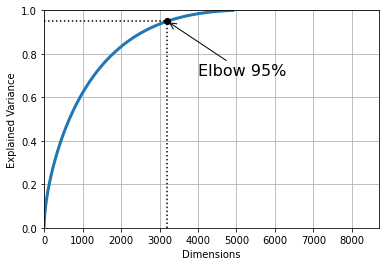

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 8700, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow 95%", xy=(3200, 0.95), xytext=(4000, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

In [ ]:
d_90 = np.argmax(cumsum>= 0.90) + 1
d_90

2558

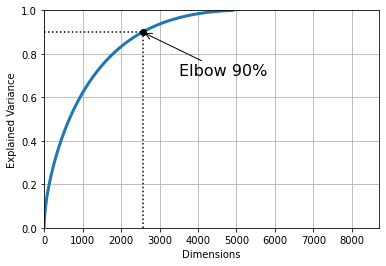

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 8700, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d_90, d_90], [0, 0.90], "k:")
plt.plot([0, d_90], [0.90, 0.90], "k:")
plt.plot(d_90, 0.90, "ko")
plt.annotate("Elbow 90%", xy=(2558, 0.90), xytext=(3500, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

In [ ]:
d_80 = np.argmax(cumsum>= 0.80) + 1
d_80

1790

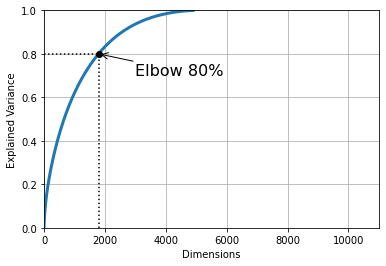

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 11000, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d_80, d_80], [0, 0.80], "k:")
plt.plot([0, d_80], [0.80, 0.80], "k:")
plt.plot(d_80, 0.80, "ko")
plt.annotate("Elbow 80%", xy=(1790, 0.80), xytext=(3000, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

**Trying Kernel PCA to ckeck inverse transform**

In [ ]:
from sklearn.decomposition import KernelPCA

**1. Linear**

In [ ]:
linear_pca = KernelPCA(n_components=2558, kernel = 'linear', fit_inverse_transform=True) # KernellPCA is good for preserving clusters of instances and also good at unrolling
X_linear_reduced = linear_pca.fit_transform(tfidf_dense)
X_linear_preimage = linear_pca.inverse_transform(X_linear_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(tfidf_dense, X_linear_preimage)

2.93576514057559e-05

In [ ]:
MSE_linear = 2.93576514057559e-05 # this is pretty small already

In [ ]:
pcaa = PCA(n_components = 0.9)
Xred = pcaa.fit_transform(tfidf_dense)
Xback = pcaa.inverse_transform(Xred)
mean_squared_error(tfidf_dense, Xback)

1.0907203344449444e-05

In [ ]:
2.93576514057559e-05 / 1.0907203344449444e-05 # KernelPCA seems to be performing almost 3 times better at preserving the original info, compared to PCA

2.691583761541925

In [ ]:
Xred.shape[1] # no components

2558

In [ ]:
type(X_linear_reduced)

numpy.ndarray

In [ ]:
X_linear_reduced.shape

(4905, 2558)

How to save and retreive
https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/

In [ ]:
#saving
np.savetxt('reduced_lin_pca.csv', X_linear_reduced, delimiter=',')
!cp reduced_lin_pca.csv "/content/drive/MyDrive/movies2012data"

In [ ]:
#loading back

data = np.loadtxt('/content/drive/MyDrive/movies2012data/reduced_lin_pca.csv', delimiter=',')

### **Search for the number of clusters K-Means**

#### **On Total Sample**

In [ ]:
data = X_linear_reduced

In [ ]:
#loading PCA matrix
data = np.loadtxt('/content/drive/MyDrive/movies2012data/reduced_lin_pca.csv', delimiter=',')

In [ ]:
data.shape

(4905, 2558)

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.cluster.vq import kmeans, vq
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
distortions = []

num_clusters = range(2, 26)#too base themes from the paper (25)

for num in num_clusters:
  cluster_centers, distortion = kmeans(data, num)
  distortions.append(distortion)

took 1h 9 min

In [ ]:
elbow_plot = pd.DataFrame({'num_clusters': num_clusters,
                           'distortions': distortions})

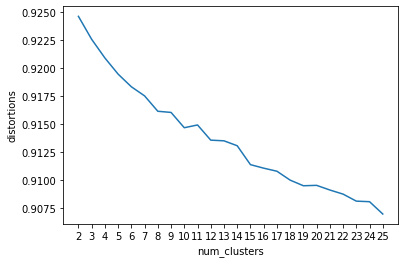

In [ ]:
sns.lineplot(x = 'num_clusters', y= 'distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

In [ ]:
num_clusters[4:15]

range(6, 17)

In [ ]:
elbow_plot2 = pd.DataFrame({'num_clusters': num_clusters[4:15],
                           'distortions': distortions[4:15]})

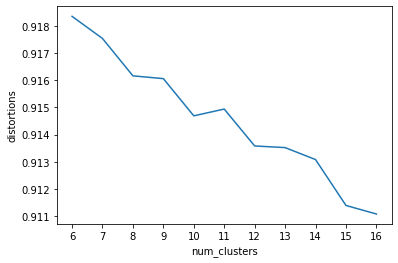

In [ ]:
sns.lineplot(x = 'num_clusters', y= 'distortions', data = elbow_plot2)
plt.xticks(num_clusters[4:15])
plt.show()

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used. Inertia: It is the sum of squared distances of samples to their closest cluster center.

**Number of clustetrs with Silhuette score**

In [ ]:
from sklearn import preprocessing
data_norm = preprocessing.normalize(data)

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_scores = []

for num in num_clusters:
  labels = KMeans(n_clusters = num, random_state = 42).fit(data_norm).labels_
  silhouette_scores.append(silhouette_score(data_norm, labels))
  print('currently calculating for ' + str(num +1) + 'th cluster')

currently calculating for 3th cluster
currently calculating for 4th cluster
currently calculating for 5th cluster
currently calculating for 6th cluster
currently calculating for 7th cluster
currently calculating for 8th cluster
currently calculating for 9th cluster
currently calculating for 10th cluster
currently calculating for 11th cluster
currently calculating for 12th cluster
currently calculating for 13th cluster
currently calculating for 14th cluster
currently calculating for 15th cluster
currently calculating for 16th cluster
currently calculating for 17th cluster
currently calculating for 18th cluster
currently calculating for 19th cluster
currently calculating for 20th cluster
currently calculating for 21th cluster
currently calculating for 22th cluster
currently calculating for 23th cluster
currently calculating for 24th cluster
currently calculating for 25th cluster
currently calculating for 26th cluster


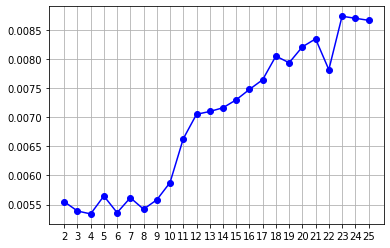

In [ ]:
plt.plot(num_clusters, silhouette_scores, 'bo-')
plt.xticks(num_clusters)
plt.grid()
plt.show()

In [ ]:
from matplotlib.pyplot import figure

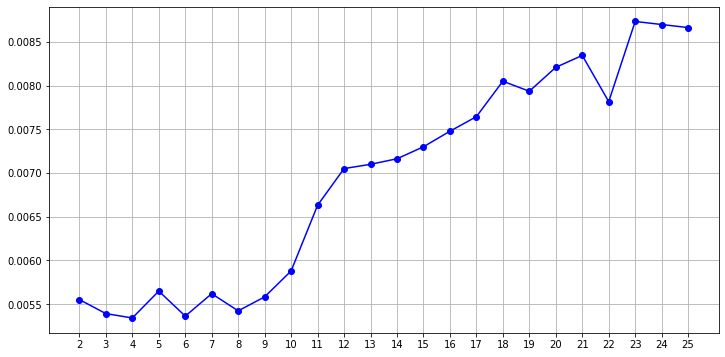

In [ ]:
figure(figsize=(12, 6))
plt.plot(num_clusters, silhouette_scores, 'bo-')
plt.xticks(num_clusters)
plt.grid()
plt.show()

Based on the visualizations so far, k = 8, 10, 12 (elbow), 12, 21 seem to perform better. 12 seems to be the consensus.
We construct visualizations with silhuette coefficients for those. 

In [ ]:
ks = [8, 10, 12, 18, 21]

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data_norm)
                for k in ks]

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

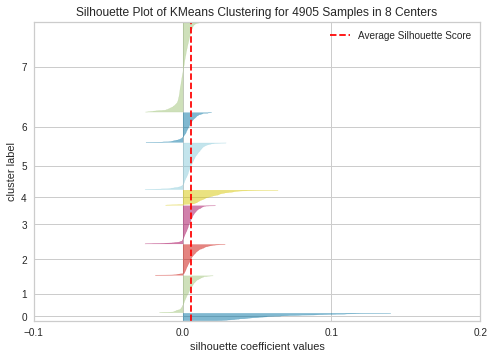

In [ ]:
visualizer1 = SilhouetteVisualizer(kmeans_per_k[0], colors = 'yellowbrick')
visualizer1.fit(data_norm)
visualizer1.show()

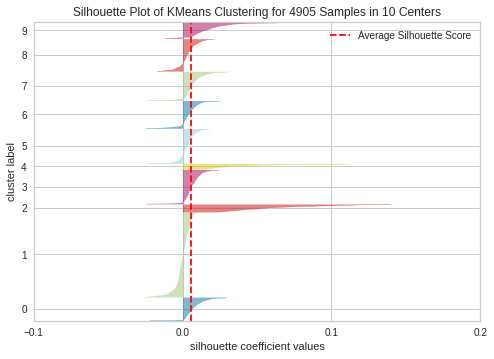

In [ ]:
visualizer2 = SilhouetteVisualizer(kmeans_per_k[1], colors = 'yellowbrick')
visualizer2.fit(data_norm)
visualizer2.show()

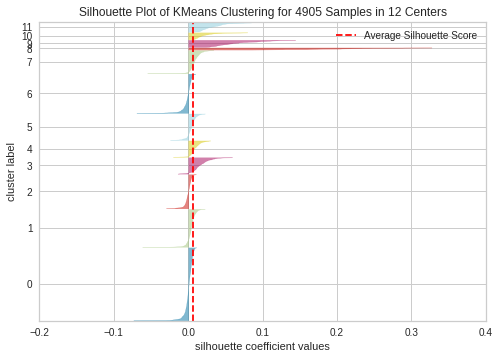

In [ ]:
visualizer3 = SilhouetteVisualizer(kmeans_per_k[2], colors = 'yellowbrick')
visualizer3.fit(data_norm)
visualizer3.show()

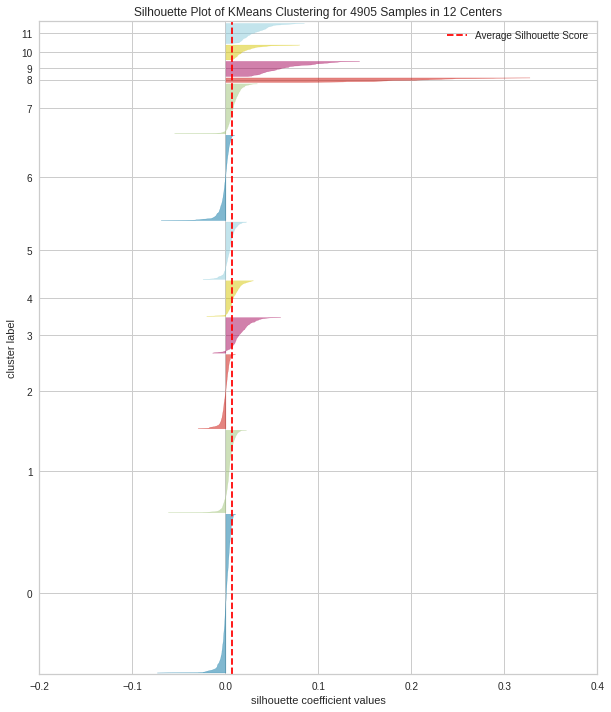

In [ ]:
figure(figsize=(10, 12))
visualizer3 = SilhouetteVisualizer(kmeans_per_k[2], colors = 'yellowbrick')
visualizer3.fit(data_norm)
visualizer3.show()

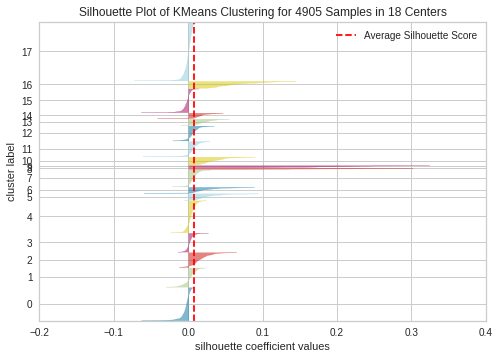

In [ ]:
visualizer4 = SilhouetteVisualizer(kmeans_per_k[3], colors = 'yellowbrick')
visualizer4.fit(data_norm)
visualizer4.show()

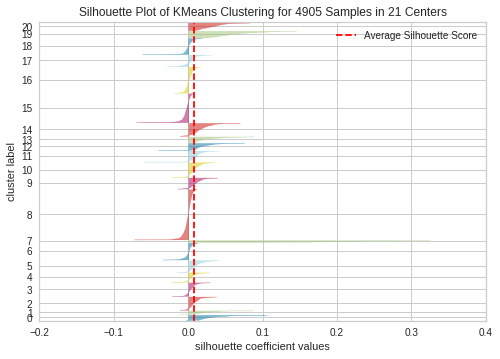

In [ ]:
visualizer4 = SilhouetteVisualizer(kmeans_per_k[4], colors = 'yellowbrick')
visualizer4.fit(data_norm)
visualizer4.show()

tey to caclulate cosine similarity fitst from tfidf, then run hierarchical

https://shravan-kuchkula.github.io/clustering_movie_plots/#9-calculate-similarity-distance

#### **Subsets**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
text = movie_sub2.summary_lemmas.values

##### **Functions**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [ ]:
from sklearn import preprocessing

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.cluster.vq import kmeans, vq
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import silhouette_score

In [ ]:
import scipy.stats

To prepare test set:
1. initiate and train tfidf vectorizer
2. intitiate pca to define number of dimensions with 90% of variance explained
3. initiate kernel PCA for those n dimensions
4. reduce the data


In [ ]:
def train_data_prep(text):
  #tfidf
  vectorizer = TfidfVectorizer(min_df = 10) #initiate vectorizer
  tfidf = vectorizer.fit_transform(text) #transform text to tfidf
  tfidf_dense = tfidf.toarray() #makes a dense matrix

  #pca to define dimensions
  pca = PCA() #initiate pca no use ion setting the var threshold here still need to calculate like below
  pca.fit(tfidf_dense)
  cumsum = np.cumsum(pca.explained_variance_ratio_)
  d = np.argmax(cumsum>= 0.90) + 1 #get the number of dimentions for 90%of varience to be explained

  #kernell pca (better for clustered data and shows lower distortion after inverse transform)
  linear_pca = KernelPCA(n_components=d, kernel = 'linear', fit_inverse_transform=False) #change to True if want to see MSU (add to the code, not writen out)
  X_linear_reduced = linear_pca.fit_transform(tfidf_dense)

  #return vectorizers for tfidf, kernelpca, tfidf matrix, pca matrix
  return vectorizer, linear_pca, tfidf_dense, X_linear_reduced


To define N of clusters:
1. Normalize the data
2. Define cluster range
3. Calculate distortion for each N clusters
4. Calculate Silhluette scores for each N clusters
5. Plot Distortions and Silhuette scores agaiins N clusters to see the fitting option

In [ ]:
#need to normalize before KMeans that corrects for the issue with eucleadian distance as the distance measure
X_reduced_norm = preprocessing.normalize(X_linear_reduced)

In [ ]:
def cluster_number_analysis(pcaed_matrix, list_cluster_nums):

  #distortions
  print('Calculating distortions... this could take a bit, 40min maybe...')
  distortions = [] #collect distorions here
  for num in list_cluster_nums:
    cluster_centers, distortion = kmeans(pcaed_matrix, num)
    distortions.append(distortion)
    print('Currently calculating for ' + str(num + 1) + 'th cluster')  

  elbow_plot = pd.DataFrame({'num_clusters': list_cluster_nums,
                             'distortions': distortions})  
  
  #silguette score
  print('Calculating Silhuette scores...')
  silhouette_scores = []

  for num in list_cluster_nums:
    labels = KMeans(n_clusters = num, random_state = 42).fit(pcaed_matrix).labels_
    silhouette_scores.append(silhouette_score(pcaed_matrix, labels))
    print('currently calculating for ' + str(num +1) + 'th cluster')


  #charting  
  print('Plotting Charts...')
  figure(figsize=(12, 6))
  plt.grid()
  sns.lineplot(x = 'num_clusters', y= 'distortions', data = elbow_plot)
  plt.xticks(list_cluster_nums)
  plt.show()
  figure(figsize=(12, 6))
  plt.plot(list_cluster_nums, silhouette_scores, 'bo-')
  plt.ylabel('silhouette scores')
  plt.xticks(list_cluster_nums)
  plt.show()



Run Kmeans clustewring for defined N clusters

In [ ]:
#train perfered kmeans
kmeans_X = KMeans(n_clusters = xx)

For new data:
1. transform to tfidf
2. reduce to pca-ed
3. normalize
4. transform with kmeans model to get distances to cluster centers
5. get the smallest distance (distance to its cluster center)


In [ ]:
def predict_new_instances(new_text, vectorizer, pca_model, kmeans_model):
  #transform to tfidf
  tfidf_new = vectorizer.transform(new_text)
  tfidf_new_dense = tfidf_new.toarray()
  #transform to pca
  new_reduced = pca_model.transform(tfidf_new_dense)
  #normalize
  new_reduced_norm = preprocessing.normalize(new_reduced)
  #transform through kmeans
  distances_new = kmeans_model.transform(new_reduced_norm) #these are distances to all clustser centers
  distance_list = []
  for i in range(len(distances_new)):
    distance_list.append(min(distances_new[i]))

  return distance_list

Run correlation analysis

In [ ]:
def calculate_correlations(distance, box_office):
  print('******************* \n*******************')
  print('Pearson R:')
  print(scipy.stats.pearsonr(distance, box_office))
  print('******************* \n*******************')
  print('Spearman R:')
  print(scipy.stats.spearmanr(distance, box_office))

#### **1985-2008 to predict 2009**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
train_full = movie_sub2[movie_sub2.year <2009]

In [ ]:
predict_full = movie_sub2[movie_sub2.year == 2009]

In [ ]:
train_text = train_full.summary_lemmas.values
predict_text = predict_full.summary_lemmas.values

In [ ]:
#shape the training data and train vectorizer models
vectorizer, linear_pca, tfidf_dense, X_linear_reduced = train_data_prep(train_text)

In [ ]:
#need to normalize before KMeans that corrects for the issue with eucleadian distance as the distance measure
train_reduced_norm = preprocessing.normalize(X_linear_reduced)

Calculating distortions... this could take a bit, 40min maybe...
Currently calculating for 26th cluster
Calculating Silguette scores...
currently calculating for 3th cluster
currently calculating for 4th cluster
currently calculating for 5th cluster
currently calculating for 6th cluster
currently calculating for 7th cluster
currently calculating for 8th cluster
currently calculating for 9th cluster
currently calculating for 10th cluster
currently calculating for 11th cluster
currently calculating for 12th cluster
currently calculating for 13th cluster
currently calculating for 14th cluster
currently calculating for 15th cluster
currently calculating for 16th cluster
currently calculating for 17th cluster
currently calculating for 18th cluster
currently calculating for 19th cluster
currently calculating for 20th cluster
currently calculating for 21th cluster
currently calculating for 22th cluster
currently calculating for 23th cluster
currently calculating for 24th cluster
currently cal

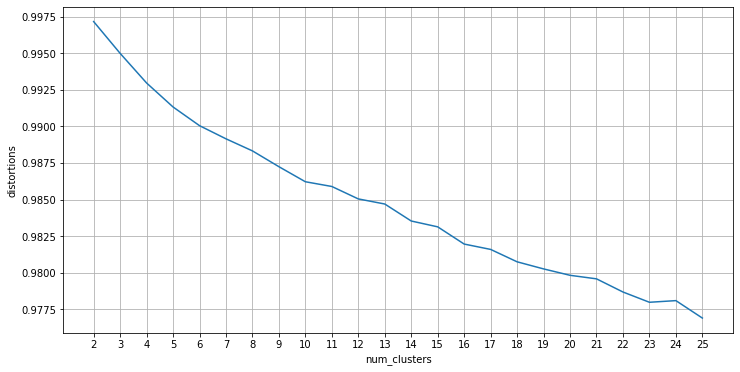

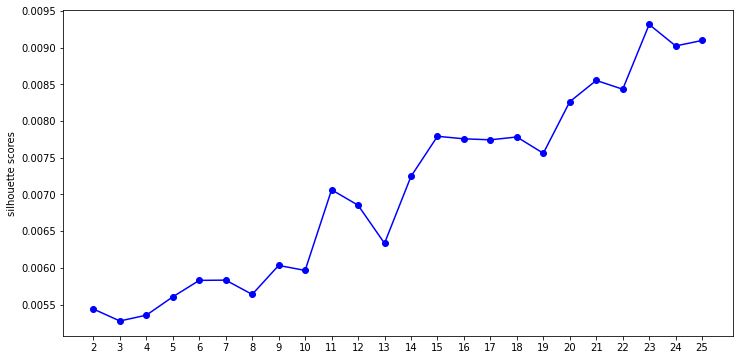

In [ ]:
num_clusters = range(2, 26)
cluster_number_analysis(pcaed_matrix = train_reduced_norm, list_cluster_nums = num_clusters)

In [ ]:
#train perfered kmeans
kmeans2_2008 = KMeans(n_clusters = 11, random_state = 42)
kmeans2_2008.fit(train_reduced_norm)

KMeans(n_clusters=11, random_state=42)

In [ ]:
distances2009 = predict_new_instances(new_text = predict_text, vectorizer = vectorizer, pca_model = linear_pca, kmeans_model = kmeans2_2008)

In [ ]:
calculate_correlations(distance = distances2009, box_office = np.log(predict_full.box_of_rev))

******************* 
*******************
Pearson R:
(-0.10223555642338876, 0.10612293605619023)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.14490381331815594, pvalue=0.02165404259439059)


In [ ]:
all_distances_train = kmeans2_2008.transform(train_reduced_norm)
distances_train = []

for i in range(len(all_distances_train)):
  distances_train.append(min(all_distances_train[i]))

calculate_correlations(distance = distances_train, box_office = np.log(train_full.box_of_rev))  


******************* 
*******************
Pearson R:
(-0.10660156316148944, 4.1003379210037025e-12)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.11678868208546908, pvalue=2.9465151312032185e-14)


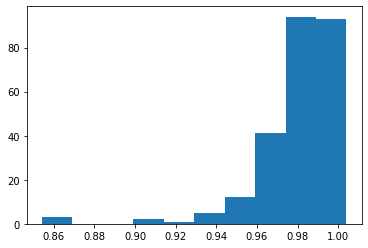

In [ ]:
plt.hist(distances2009)
plt.show()

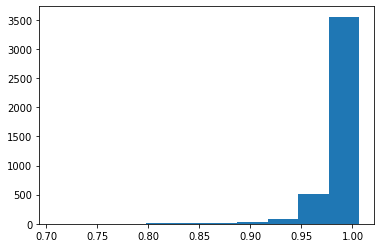

In [ ]:
plt.hist(distances_train)
plt.show()

In [ ]:
nulls = np.array(distances_train) == 0

In [ ]:
np.sum(nulls)

0

#### **1985-2009 to predict 2010**

In [ ]:
train_full = movie_sub2[movie_sub2.year <20010]

In [ ]:
predict_full = movie_sub2[movie_sub2.year == 2010]

In [ ]:
train_text = train_full.summary_lemmas.values
predict_text = predict_full.summary_lemmas.values

In [ ]:
#shape the training data and train vectorizer models
vectorizer, linear_pca, tfidf_dense, X_linear_reduced = train_data_prep(train_text)

In [ ]:
#need to normalize before KMeans that corrects for the issue with eucleadian distance as the distance measure
train_reduced_norm = preprocessing.normalize(X_linear_reduced)

Calculating distortions... this could take a bit, 40min maybe...
Currently calculating for 3th cluster
Currently calculating for 4th cluster
Currently calculating for 5th cluster
Currently calculating for 6th cluster
Currently calculating for 7th cluster
Currently calculating for 8th cluster
Currently calculating for 9th cluster
Currently calculating for 10th cluster
Currently calculating for 11th cluster
Currently calculating for 12th cluster
Currently calculating for 13th cluster
Currently calculating for 14th cluster
Currently calculating for 15th cluster
Currently calculating for 16th cluster
Currently calculating for 17th cluster
Currently calculating for 18th cluster
Currently calculating for 19th cluster
Currently calculating for 20th cluster
Currently calculating for 21th cluster
Currently calculating for 22th cluster
Currently calculating for 23th cluster
Currently calculating for 24th cluster
Currently calculating for 25th cluster
Currently calculating for 26th cluster
Calcul

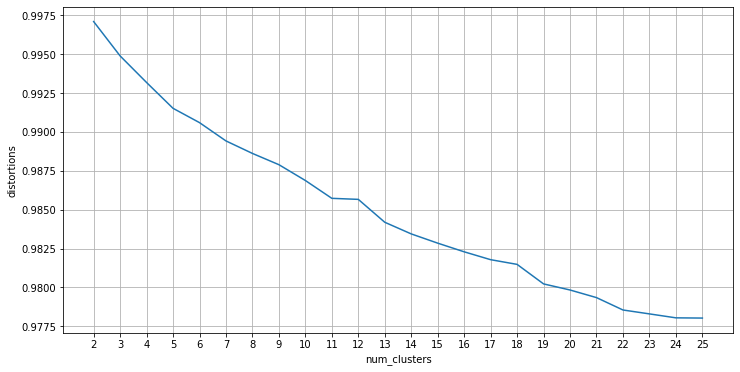

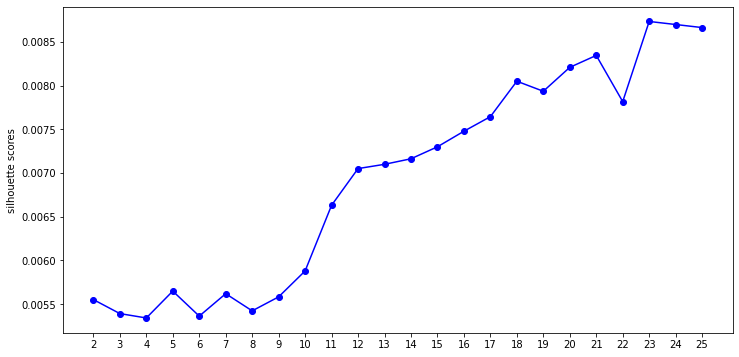

In [ ]:
num_clusters = range(2, 26)
cluster_number_analysis(pcaed_matrix = train_reduced_norm, list_cluster_nums = num_clusters)

In [ ]:
#train perfered kmeans
kmeans2_2009 = KMeans(n_clusters = 12, random_state = 42)
kmeans2_2009.fit(train_reduced_norm)

KMeans(n_clusters=12, random_state=42)

In the future set the seed!!!

In [ ]:
distances2010 = predict_new_instances(new_text = predict_text, vectorizer = vectorizer, pca_model = linear_pca, kmeans_model = kmeans2_2009)

In [ ]:
predict_text.shape

(0,)

In [ ]:
calculate_correlations(distance = distances2010, box_office = np.log(predict_full.box_of_rev))

******************* 
*******************
Pearson R:
(0.04733666344325952, 0.47791537489626384)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.09438331120772969, pvalue=0.15638255075992422)


In [ ]:
all_distances_train = kmeans2_2009.transform(train_reduced_norm)
distances_train = []

for i in range(len(all_distances_train)):
  distances_train.append(min(all_distances_train[i]))

calculate_correlations(distance = distances_train, box_office = np.log(train_full.box_of_rev))  


******************* 
*******************
Pearson R:
(-0.09095822268353725, 1.7486768798313474e-10)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.12365446117297839, pvalue=3.580194684259133e-18)


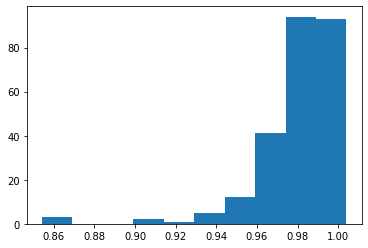

In [ ]:
plt.hist(distances2009)
plt.show()

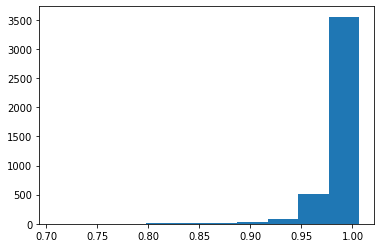

In [ ]:
plt.hist(distances_train)
plt.show()

In [ ]:
nulls = np.array(distances_train) == 0

In [ ]:
np.sum(nulls)

0

#### **1985-2010 to predict 2011**

In [ ]:
train_full = movie_sub2[movie_sub2.year <2011]

In [ ]:
predict_full = movie_sub2[movie_sub2.year == 2011]

In [ ]:
train_text = train_full.summary_lemmas.values
predict_text = predict_full.summary_lemmas.values

In [ ]:
#shape the training data and train vectorizer models
vectorizer, linear_pca, tfidf_dense, X_linear_reduced = train_data_prep(train_text)

In [ ]:
#need to normalize before KMeans that corrects for the issue with eucleadian distance as the distance measure
train_reduced_norm = preprocessing.normalize(X_linear_reduced)

Calculating distortions... this could take a bit, 40min maybe...
Currently calculating for 3th cluster
Currently calculating for 4th cluster
Currently calculating for 5th cluster
Currently calculating for 6th cluster
Currently calculating for 7th cluster
Currently calculating for 8th cluster
Currently calculating for 9th cluster
Currently calculating for 10th cluster
Currently calculating for 11th cluster
Currently calculating for 12th cluster
Currently calculating for 13th cluster
Currently calculating for 14th cluster
Currently calculating for 15th cluster
Currently calculating for 16th cluster
Currently calculating for 17th cluster
Currently calculating for 18th cluster
Currently calculating for 19th cluster
Currently calculating for 20th cluster
Currently calculating for 21th cluster
Currently calculating for 22th cluster
Currently calculating for 23th cluster
Currently calculating for 24th cluster
Currently calculating for 25th cluster
Currently calculating for 26th cluster
Calcul

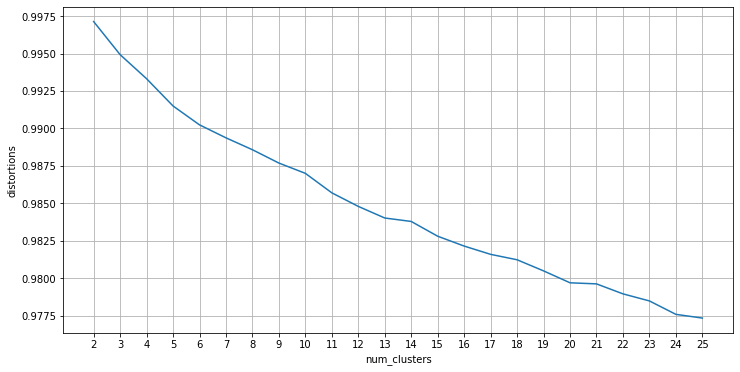

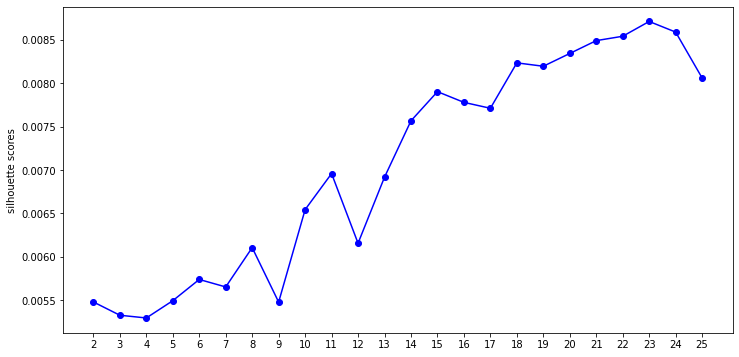

In [ ]:
num_clusters = range(2, 26)
cluster_number_analysis(pcaed_matrix = train_reduced_norm, list_cluster_nums = num_clusters)

In [ ]:
#train perfered kmeans
kmeans2_2010 = KMeans(n_clusters = 15, random_state = 42)
kmeans2_2010.fit(train_reduced_norm)

KMeans(n_clusters=15, random_state=42)

In the future set the seed!!!

In [ ]:
distances2011 = predict_new_instances(new_text = predict_text, vectorizer = vectorizer, pca_model = linear_pca, kmeans_model = kmeans2_2010)

In [ ]:
predict_text.shape

(0,)

In [ ]:
calculate_correlations(distance = distances2011, box_office = np.log(predict_full.box_of_rev))

******************* 
*******************
Pearson R:
(-0.09552799042048551, 0.1598543917103236)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.02001599611737976, pvalue=0.7688625688919273)


In [ ]:
all_distances_train = kmeans2_2010.transform(train_reduced_norm)
distances_train = []

for i in range(len(all_distances_train)):
  distances_train.append(min(all_distances_train[i]))

calculate_correlations(distance = distances_train, box_office = np.log(train_full.box_of_rev))  


******************* 
*******************
Pearson R:
(-0.09835307225931571, 1.499126067777146e-11)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.14698182130364415, pvalue=4.744251664023e-24)


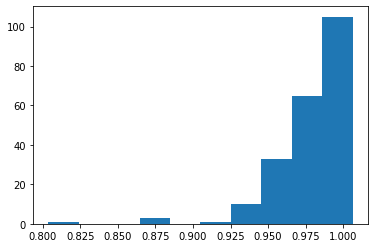

In [ ]:
plt.hist(distances2011)
plt.show()

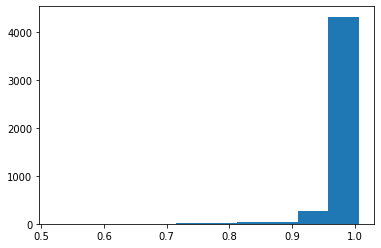

In [ ]:
plt.hist(distances_train)
plt.show()

In [ ]:
nulls = np.array(distances_train) == 0

In [ ]:
np.sum(nulls)

0

#### **1985-2008 to predict 2009 Only Drama**

In [ ]:
movie_sub2.head()

,Unnamed: 0,Unnamed: 0.1,wiki_movieID,summary,movie_name,box_of_rev,run_time,country_USA,Drama,Comedy,Thriller,Romance Film,Action,year,summary_noname,summary_lemmas
0,0,0,595909,Seventh day Adventist Church pastor Michael Ch...,A Cry in the Dark,6908797.0,121.0,1,1,0,0,0,0,1988,pastor wife sons daughter camping holiday fam...,pastor wife son daughter camping holiday famil...
1,1,1,1952976,plot The film opens in year as a young girl Da...,Dark Water,49483352.0,105.0,1,1,0,1,0,0,2005,film opens young girl stands outside school r...,film open young girl stand outside school rain...
2,2,2,24225279,The story begins with Hannah a young Jewish te...,Sing,2260616.0,98.0,1,1,0,0,0,0,1989,story begins young teen completing senior yea...,story begin young teen completing senior year ...
3,3,3,18188932,Milan and Goran are two criminals who smuggle ...,Up and Down,2705163.0,108.0,0,1,1,0,0,0,2004,criminals smuggle illegal immigrants complete...,criminal smuggle illegal immigrant complete sm...
4,4,4,1480747,plot Following the sudden death of Kids father...,House Party 2,19438638.0,94.0,1,0,1,0,0,0,1991,following sudden death father pop local churc...,following sudden death father pop local church...


In [ ]:
train_full_drama = movie_sub2[(movie_sub2.year <2009) & (movie_sub2.Drama == 1)]

In [ ]:
len(train_full)

4209

In [ ]:
len(train_full_drama)

2134

In [ ]:
predict_full_drama = movie_sub2[(movie_sub2.year == 2009) & (movie_sub2.Drama == 1)]

In [ ]:
len(predict_full)

251

In [ ]:
len(predict_full_drama)

131

In [ ]:
train_text_drama = train_full_drama.summary_lemmas.values
predict_text_drama = predict_full_drama.summary_lemmas.values

In [ ]:
#shape the training data and train vectorizer models
vectorizer, linear_pca, tfidf_dense, X_linear_reduced = train_data_prep(train_text_drama)

In [ ]:
#need to normalize before KMeans that corrects for the issue with eucleadian distance as the distance measure
train_reduced_norm = preprocessing.normalize(X_linear_reduced)

Calculating distortions... this could take a bit, 40min maybe...
Currently calculating for 3th cluster
Currently calculating for 4th cluster
Currently calculating for 5th cluster
Currently calculating for 6th cluster
Currently calculating for 7th cluster
Currently calculating for 8th cluster
Currently calculating for 9th cluster
Currently calculating for 10th cluster
Currently calculating for 11th cluster
Currently calculating for 12th cluster
Currently calculating for 13th cluster
Currently calculating for 14th cluster
Currently calculating for 15th cluster
Currently calculating for 16th cluster
Currently calculating for 17th cluster
Currently calculating for 18th cluster
Currently calculating for 19th cluster
Currently calculating for 20th cluster
Currently calculating for 21th cluster
Currently calculating for 22th cluster
Currently calculating for 23th cluster
Currently calculating for 24th cluster
Currently calculating for 25th cluster
Currently calculating for 26th cluster
Calcul

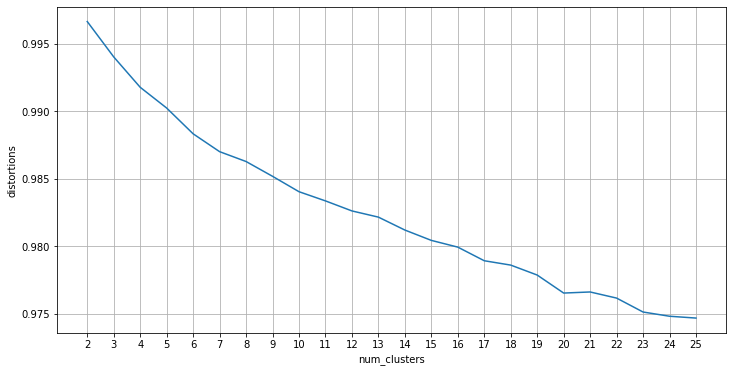

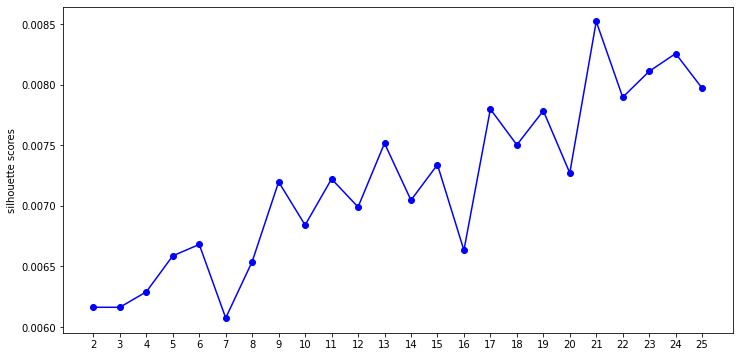

In [ ]:
num_clusters = range(2, 26)
cluster_number_analysis(pcaed_matrix = train_reduced_norm, list_cluster_nums = num_clusters)

In [ ]:
#train perfered kmeans
kmeans2_2008 = KMeans(n_clusters = 13, random_state = 42)
kmeans2_2008.fit(train_reduced_norm)

KMeans(n_clusters=13, random_state=42)

In the future set the seed!!!

In [ ]:
distances2009 = predict_new_instances(new_text = predict_text_drama, vectorizer = vectorizer, pca_model = linear_pca, kmeans_model = kmeans2_2009)

In [ ]:
calculate_correlations(distance = distances2009, box_office = np.log(predict_full_drama.box_of_rev))

******************* 
*******************
Pearson R:
(-0.05603470026430754, 0.5249723327216026)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.08750333635829818, pvalue=0.3203053557645129)


In [ ]:
all_distances_train = kmeans2_2008.transform(train_reduced_norm)
distances_train = []

for i in range(len(all_distances_train)):
  distances_train.append(min(all_distances_train[i]))

calculate_correlations(distance = distances_train, box_office = np.log(train_full_drama.box_of_rev))  


******************* 
*******************
Pearson R:
(-0.12231515091212358, 1.441690822624734e-08)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.15432970753856795, pvalue=7.604336486972694e-13)


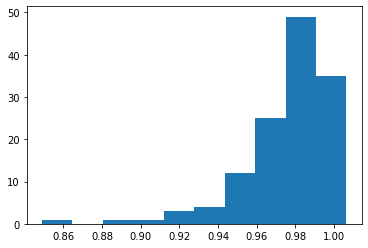

In [ ]:
plt.hist(distances2009)
plt.show()

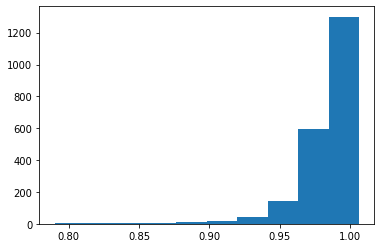

In [ ]:
plt.hist(distances_train)
plt.show()

#### **1985-2009 to predict 2010 Only Drama**

In [ ]:
train_full_drama = movie_sub2[(movie_sub2.year <2010) & (movie_sub2.Drama == 1)]

In [ ]:
predict_full_drama = movie_sub2[(movie_sub2.year == 2010) & (movie_sub2.Drama == 1)]

In [ ]:
len(predict_full_drama)

129

In [ ]:
train_text_drama = train_full_drama.summary_lemmas.values
predict_text_drama = predict_full_drama.summary_lemmas.values

In [ ]:
#shape the training data and train vectorizer models
vectorizer, linear_pca, tfidf_dense, X_linear_reduced = train_data_prep(train_text_drama)

In [ ]:
#need to normalize before KMeans that corrects for the issue with eucleadian distance as the distance measure
train_reduced_norm = preprocessing.normalize(X_linear_reduced)

Calculating distortions... this could take a bit, 40min maybe...
Currently calculating for 3th cluster
Currently calculating for 4th cluster
Currently calculating for 5th cluster
Currently calculating for 6th cluster
Currently calculating for 7th cluster
Currently calculating for 8th cluster
Currently calculating for 9th cluster
Currently calculating for 10th cluster
Currently calculating for 11th cluster
Currently calculating for 12th cluster
Currently calculating for 13th cluster
Currently calculating for 14th cluster
Currently calculating for 15th cluster
Currently calculating for 16th cluster
Currently calculating for 17th cluster
Currently calculating for 18th cluster
Currently calculating for 19th cluster
Currently calculating for 20th cluster
Currently calculating for 21th cluster
Currently calculating for 22th cluster
Currently calculating for 23th cluster
Currently calculating for 24th cluster
Currently calculating for 25th cluster
Currently calculating for 26th cluster
Calcul

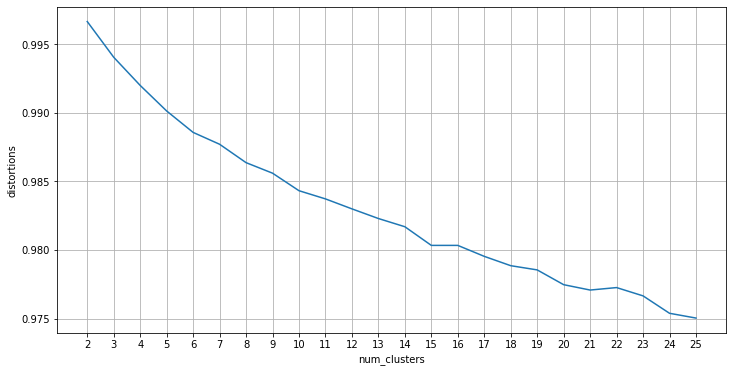

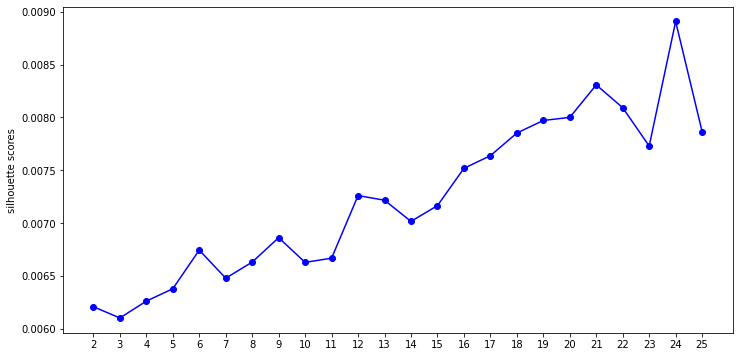

In [ ]:
num_clusters = range(2, 26)
cluster_number_analysis(pcaed_matrix = train_reduced_norm, list_cluster_nums = num_clusters)

In [ ]:
#train perfered kmeans
kmeans2_2009 = KMeans(n_clusters = 12, random_state = 42)
kmeans2_2009.fit(train_reduced_norm)

KMeans(n_clusters=12, random_state=42)

In the future set the seed!!!

In [ ]:
distances2010 = predict_new_instances(new_text = predict_text_drama, vectorizer = vectorizer, pca_model = linear_pca, kmeans_model = kmeans2_2009)

In [ ]:
calculate_correlations(distance = distances2010, box_office = np.log(predict_full_drama.box_of_rev))

******************* 
*******************
Pearson R:
(-0.09332357046451267, 0.2928304017518091)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.18339669051878357, pvalue=0.037489696499681015)


In [ ]:
all_distances_train = kmeans2_2009.transform(train_reduced_norm)
distances_train = []

for i in range(len(all_distances_train)):
  distances_train.append(min(all_distances_train[i]))

calculate_correlations(distance = distances_train, box_office = np.log(train_full_drama.box_of_rev))  


******************* 
*******************
Pearson R:
(-0.11644773589743163, 2.7313326378351396e-08)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.13427215839701234, pvalue=1.4005990832782238e-10)


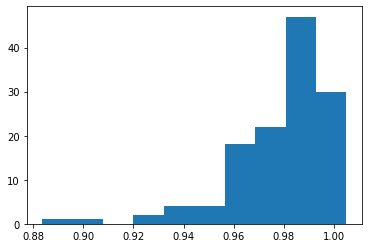

In [ ]:
plt.hist(distances2010)
plt.show()

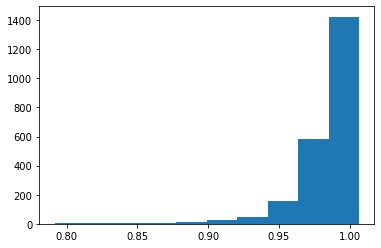

In [ ]:
plt.hist(distances_train)
plt.show()

#### **1985-2010 to predict 2011 Only Drama**

In [ ]:
train_full_drama = movie_sub2[(movie_sub2.year <2011) & (movie_sub2.Drama == 1)]

In [ ]:
predict_full_drama = movie_sub2[(movie_sub2.year == 2011) & (movie_sub2.Drama == 1)]

In [ ]:
len(predict_full_drama)

121

In [ ]:
train_text_drama = train_full_drama.summary_lemmas.values
predict_text_drama = predict_full_drama.summary_lemmas.values

In [ ]:
#shape the training data and train vectorizer models
vectorizer, linear_pca, tfidf_dense, X_linear_reduced = train_data_prep(train_text_drama)

In [ ]:
#need to normalize before KMeans that corrects for the issue with eucleadian distance as the distance measure
train_reduced_norm = preprocessing.normalize(X_linear_reduced)

Calculating distortions... this could take a bit, 40min maybe...
Currently calculating for 3th cluster
Currently calculating for 4th cluster
Currently calculating for 5th cluster
Currently calculating for 6th cluster
Currently calculating for 7th cluster
Currently calculating for 8th cluster
Currently calculating for 9th cluster
Currently calculating for 10th cluster
Currently calculating for 11th cluster
Currently calculating for 12th cluster
Currently calculating for 13th cluster
Currently calculating for 14th cluster
Currently calculating for 15th cluster
Currently calculating for 16th cluster
Currently calculating for 17th cluster
Currently calculating for 18th cluster
Currently calculating for 19th cluster
Currently calculating for 20th cluster
Currently calculating for 21th cluster
Currently calculating for 22th cluster
Currently calculating for 23th cluster
Currently calculating for 24th cluster
Currently calculating for 25th cluster
Currently calculating for 26th cluster
Calcul

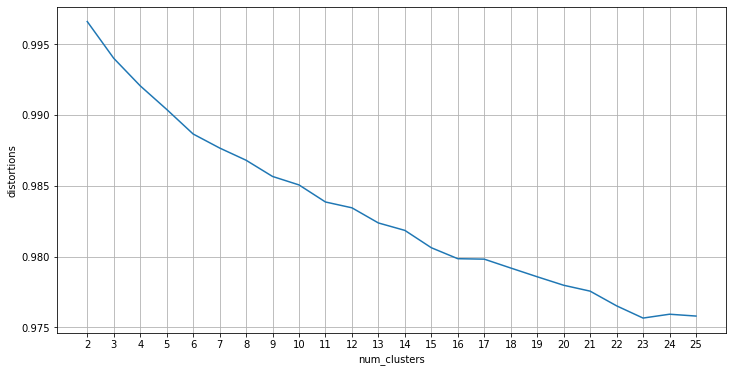

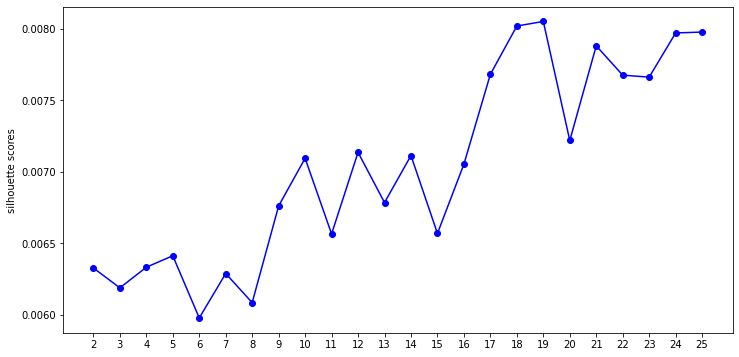

In [ ]:
num_clusters = range(2, 26)
cluster_number_analysis(pcaed_matrix = train_reduced_norm, list_cluster_nums = num_clusters)

In [ ]:
#train perfered kmeans
kmeans2_2011 = KMeans(n_clusters = 10, random_state = 42)
kmeans2_2011.fit(train_reduced_norm)

KMeans(n_clusters=10, random_state=42)

In the future set the seed!!!

In [ ]:
distances2011 = predict_new_instances(new_text = predict_text_drama, vectorizer = vectorizer, pca_model = linear_pca, kmeans_model = kmeans2_2011)

In [ ]:
calculate_correlations(distance = distances2011, box_office = np.log(predict_full_drama.box_of_rev))

******************* 
*******************
Pearson R:
(-0.08094498693971865, 0.37745135411768155)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.048895813575396276, pvalue=0.5943175986517499)


In [ ]:
all_distances_train = kmeans2_2011.transform(train_reduced_norm)
distances_train = []

for i in range(len(all_distances_train)):
  distances_train.append(min(all_distances_train[i]))

calculate_correlations(distance = distances_train, box_office = np.log(train_full_drama.box_of_rev))  


******************* 
*******************
Pearson R:
(-0.13192821475967503, 9.170880805308144e-11)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.15884273602743576, pvalue=5.3856323660713815e-15)


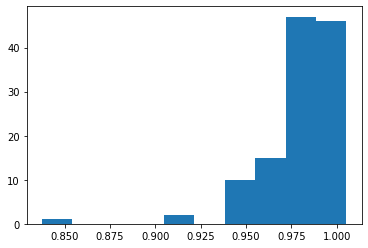

In [ ]:
plt.hist(distances2011)
plt.show()

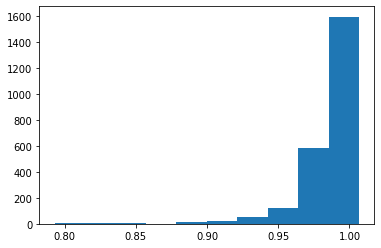

In [ ]:
plt.hist(distances_train)
plt.show()

### **Agglomerative clustering**

#### **Functions**

<u>1. Preparing training data<u>

*Same function as used in K-Means*

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn import preprocessing

With PCA

In [ ]:
def train_data_prep(text):
  #tfidf
  vectorizer = TfidfVectorizer(min_df = 10) #initiate vectorizer
  tfidf = vectorizer.fit_transform(text) #transform text to tfidf
  tfidf_dense = tfidf.toarray() #makes a dense matrix

  #pca to define dimensions
  pca = PCA() #initiate pca no use ion setting the var threshold here still need to calculate like below
  pca.fit(tfidf_dense)
  cumsum = np.cumsum(pca.explained_variance_ratio_)
  d = np.argmax(cumsum>= 0.90) + 1 #get the number of dimentions for 90%of varience to be explained

  #kernell pca (better for clustered data and shows lower distortion after inverse transform)
  linear_pca = KernelPCA(n_components=d, kernel = 'linear', fit_inverse_transform=False) #change to True if want to see MSU (add to the code, not writen out)
  X_linear_reduced = linear_pca.fit_transform(tfidf_dense)

  #return vectorizers for tfidf, kernelpca, tfidf matrix, pca matrix
  return vectorizer, linear_pca, tfidf_dense, X_linear_reduced


Without PCA

In [ ]:
def train_data_prep_simpl(text):
  #tfidf
  vectorizer = TfidfVectorizer(min_df = 10) #initiate vectorizer
  tfidf = vectorizer.fit_transform(text) #transform text to tfidf
  tfidf_dense = tfidf.toarray() #makes a dense matrix
  tfidf_norm = preprocessing.normalize(tfidf_dense)

  #return vectorizers for tfidf, kernelpca, tfidf matrix, pca matrix
  return vectorizer, tfidf_norm

<u>2. Run the chart for cluster number<u>

In [ ]:
import scipy.cluster.hierarchy as sch 
import matplotlib.pyplot as plt
from scipy import spatial

In [ ]:
#normalize the data first!
#plt.figure(figsize=(20,15))
#plt.title("Dendogram")
#plt.yticks(np.arange(0, 6, 0.1))
#dend = sch.dendrogram(sch.linkage(DATA, method = 'ward'))

<u>3. Get cluster centers from agglomerative clustering<u>

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
def get_cluster_centers(n_clusters, data):
  agl = AgglomerativeClustering(linkage = 'ward', affinity = 'euclidean', n_clusters = n_clusters) #define the model
  agl_model = agl.fit(data) #fit the model
  clusters = agl_model.fit_predict(data) #getting clusters (numbers)

  data_as_df = pd.DataFrame(data) #convert data into df
  data_as_df['Clusters'] = clusters
  clust_cent = data_as_df.groupby(['Clusters']).mean() #cluster centres is the mean of all in the cluster
  clust_cent_list = clust_cent.values.tolist() #get cluster centers to list of lists
  return clust_cent_list


<u>4. Get distance for new instances <u>

With PCA

In [ ]:
def predict_new_instances(new_text, clust_cent_list, vectorizer, pca_model):
  #transform to tfidf
  tfidf_new = vectorizer.transform(new_text)
  tfidf_new_dense = tfidf_new.toarray()
  #transform to pca
  new_reduced = pca_model.transform(tfidf_new_dense)
  #normalize
  new_reduced_norm = preprocessing.normalize(new_reduced)

  #get cluster distances
  distance_list = []
  for i in range(len(new_reduced_norm)): #for each instance
    all_distances = [] # distance to all clisters for instance i
    for dist in clust_cent_list: # for each culster center
      all_distances.append(spatial.distance.cosine(new_reduced_norm[i], dist)) #calculate diastance
    min_dist = min(all_distances) #find minimum distance to instance
    distance_list.append(min_dist) # append minimum distance to the main distance list

  return distance_list

Without PCA

In [ ]:
def predict_new_instances_simpl(new_text, clust_cent_list, vectorizer):
  #transform to tfidf
  tfidf_new = vectorizer.transform(new_text)
  tfidf_new_dense = tfidf_new.toarray()

  #normalize
  new_norm = preprocessing.normalize(tfidf_new_dense)

  #get cluster distances
  distance_list = []
  for i in range(len(new_norm)): #for each instance
    all_distances = [] # distance to all clisters for instance i
    for dist in clust_cent_list: # for each culster center
      all_distances.append(spatial.distance.cosine(new_norm[i], dist)) #calculate diastance
    min_dist = min(all_distances) #find minimum distance to instance
    distance_list.append(min_dist) # append minimum distance to the main distance list

  return distance_list

<u>5. Calculate correlations

In [ ]:
def calculate_correlations(distance, box_office):
  print('******************* \n*******************')
  print('Pearson R:')
  print(scipy.stats.pearsonr(distance, box_office))
  print('******************* \n*******************')
  print('Spearman R:')
  print(scipy.stats.spearmanr(distance, box_office))

#### **1985-2008 to predict 2009 PCA**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
train_full09 = movie_sub2[movie_sub2.year <2009]
predict_full09 = movie_sub2[movie_sub2.year == 2009]
train_text09 = train_full09.summary_lemmas.values
predict_text09 = predict_full09.summary_lemmas.values

In [ ]:
vectorizer09, linear_pca09, tfidf_dense09, train_linear_reduced09 = train_data_prep(train_text09)

In [ ]:
train_linear_norm09 = preprocessing.normalize(train_linear_reduced09)

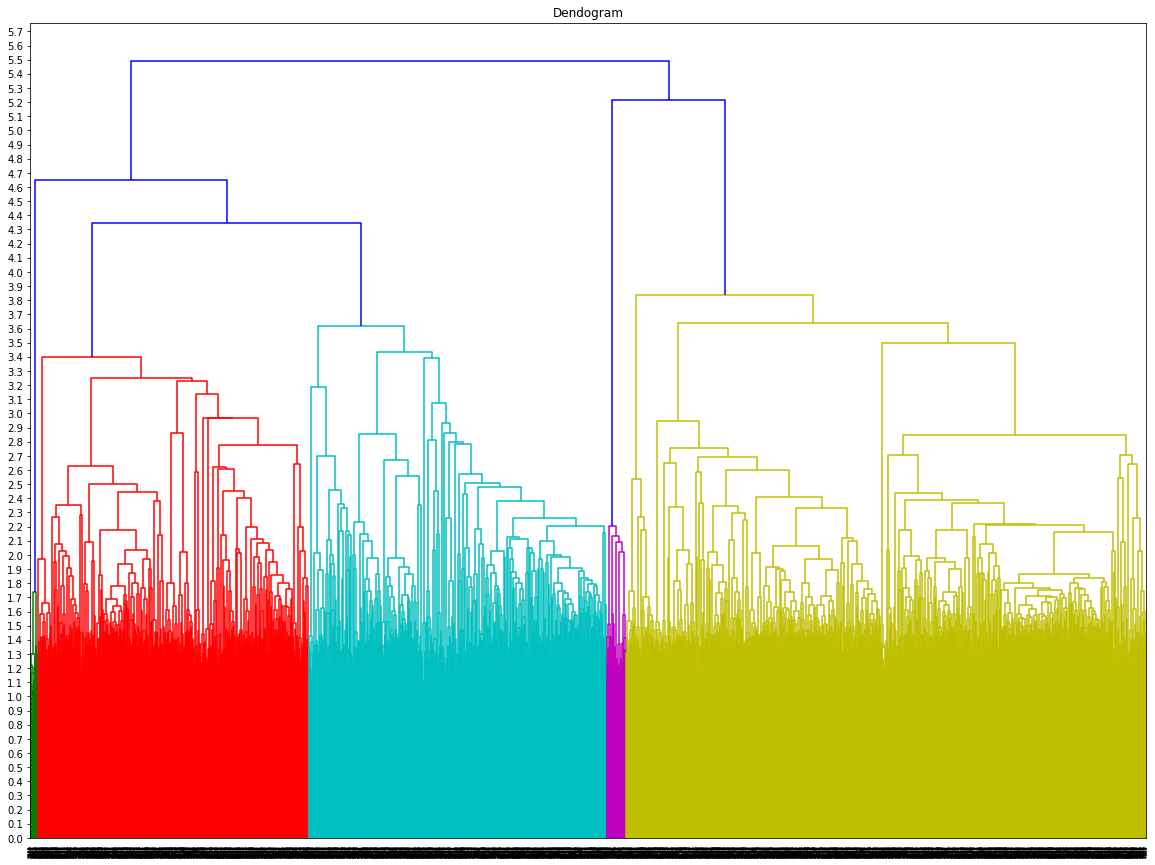

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Dendogram")
plt.yticks(np.arange(0, 6, 0.1))
dend = sch.dendrogram(sch.linkage(train_linear_norm09, method = 'ward'))

Going with 8 clisters to split a bit the big yellow cluster. Will then try an alternative with 5 clusters.

In [ ]:
clust_cent_list09 = get_cluster_centers(n_clusters = 8, data = train_linear_norm09)

In [ ]:
distances09 = predict_new_instances(predict_text09, clust_cent_list = clust_cent_list09, vectorizer = vectorizer09, pca_model = linear_pca09)

In [ ]:
calculate_correlations(distances09, predict_full09.box_of_rev)

******************* 
*******************
Pearson R:
(-0.09532580375276309, 0.13203171244580483)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.05896490229557958, pvalue=0.3522020638611658)


*Trying for 5 clusters*

In [ ]:
clust_cent_list09_5 = get_cluster_centers(n_clusters = 5, data = train_linear_norm09)

In [ ]:
distances09_5 = predict_new_instances(predict_text09, clust_cent_list = clust_cent_list09_5, vectorizer = vectorizer09, pca_model = linear_pca09)

In [ ]:
calculate_correlations(distances09_5, predict_full09.box_of_rev)

******************* 
*******************
Pearson R:
(-0.15619998080902606, 0.013228905393329883)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.2003202428381711, pvalue=0.0014216146375603234)


#### **1985-2008 to predict 2009 FULL**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
train_full09 = movie_sub2[movie_sub2.year <2009]
predict_full09 = movie_sub2[movie_sub2.year == 2009]
train_text09 = train_full09.summary_lemmas.values
predict_text09 = predict_full09.summary_lemmas.values

In [ ]:
vectorizer09, tfidf_norm09 = train_data_prep_simpl(train_text09)

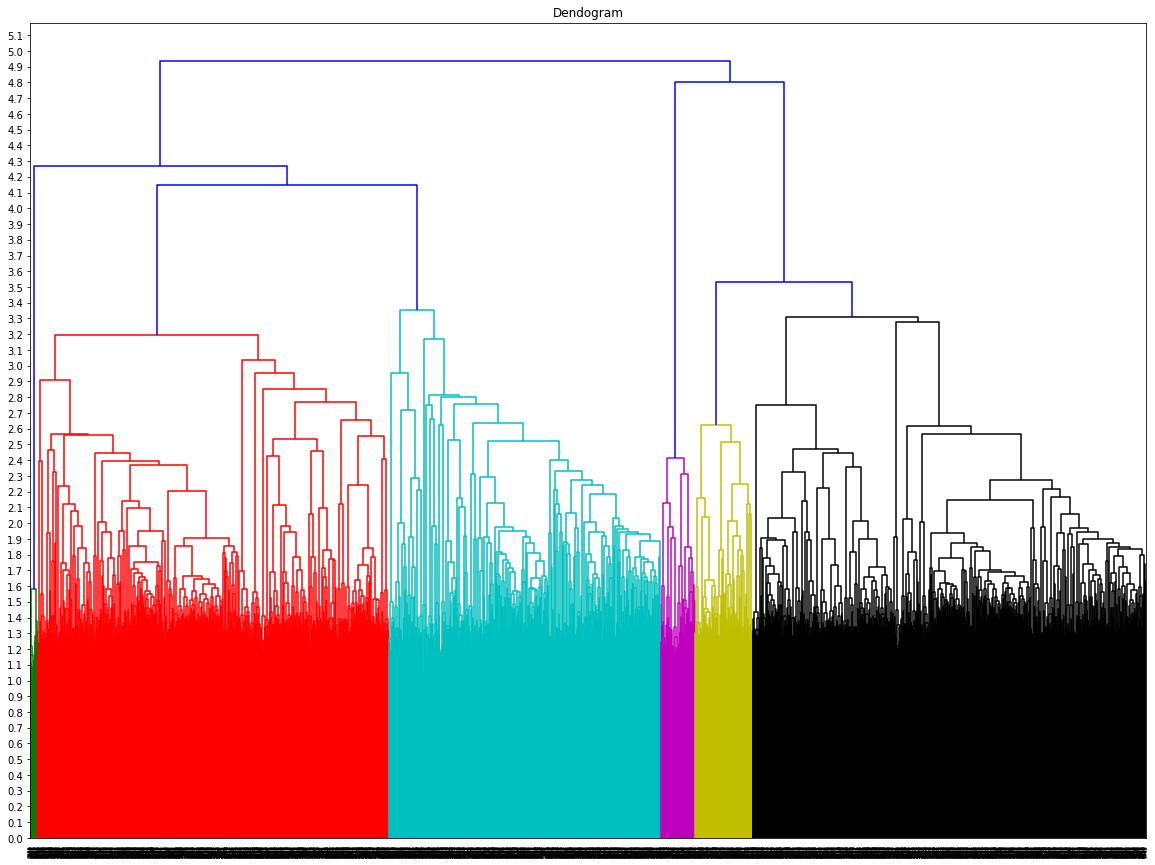

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Dendogram")
plt.yticks(np.arange(0, 6, 0.1))
dend = sch.dendrogram(sch.linkage(tfidf_norm09, method = 'ward'))

In [ ]:
clust_cent_list09 = get_cluster_centers(n_clusters = 6, data = tfidf_norm09)

In [ ]:
distances09 = predict_new_instances_simpl(predict_text09, clust_cent_list = clust_cent_list09, vectorizer = vectorizer09)

In [ ]:
calculate_correlations(distances09, np.log(predict_full09.box_of_rev))

******************* 
*******************
Pearson R:
(-0.21179219537169225, 0.000732646400897712)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.13983911971162966, pvalue=0.02673907784333392)


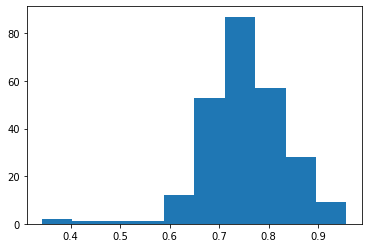

In [ ]:
plt.hist(distances09)
plt.show()

#### **1985-2009 to predict 2010 with PCA**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
train_full10 = movie_sub2[movie_sub2.year <2010]
predict_full10 = movie_sub2[movie_sub2.year == 2010]
train_text10 = train_full10.summary_lemmas.values
predict_text10 = predict_full10.summary_lemmas.values

In [ ]:
vectorizer10, linear_pca10, tfidf_dense10, train_linear_reduced10 = train_data_prep(train_text10)

In [ ]:
train_linear_norm10 = preprocessing.normalize(train_linear_reduced10)

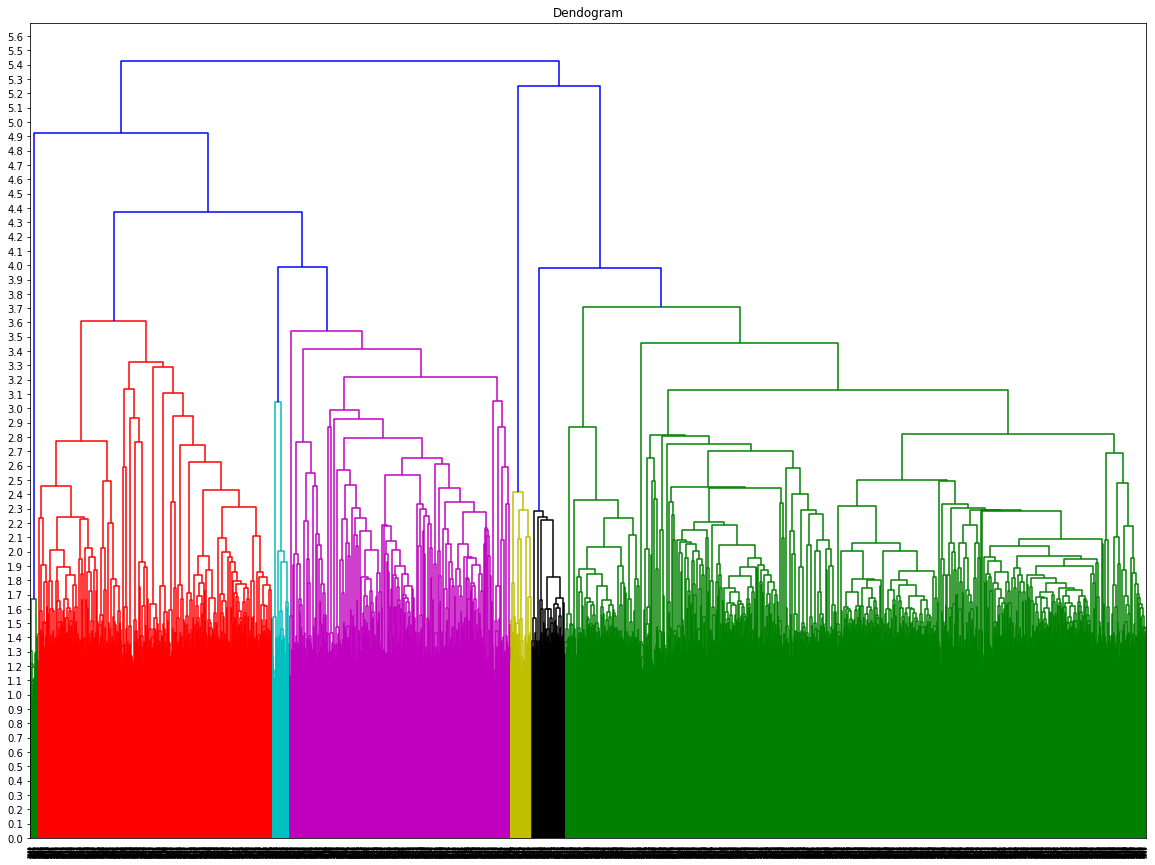

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Dendogram")
plt.yticks(np.arange(0, 6, 0.1))
dend = sch.dendrogram(sch.linkage(train_linear_norm10, method = 'ward'))

In [ ]:
clust_cent_list10 = get_cluster_centers(n_clusters = 8, data = train_linear_norm10)

In [ ]:
distances10 = predict_new_instances(predict_text10, clust_cent_list = clust_cent_list10, vectorizer = vectorizer10, pca_model = linear_pca10)

In [ ]:
calculate_correlations(distances10, predict_full10.box_of_rev)

******************* 
*******************
Pearson R:
(0.0018452502765304176, 0.9779428653550486)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.10231262144289031, pvalue=0.12428810654980908)


#### **1985-2009 to predict 2010 FULL**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
train_full10 = movie_sub2[movie_sub2.year <2010]
predict_full10 = movie_sub2[movie_sub2.year == 2010]
train_text10 = train_full10.summary_lemmas.values
predict_text10 = predict_full10.summary_lemmas.values

In [ ]:
vectorizer10, tfidf_norm10 = train_data_prep_simpl(train_text10)

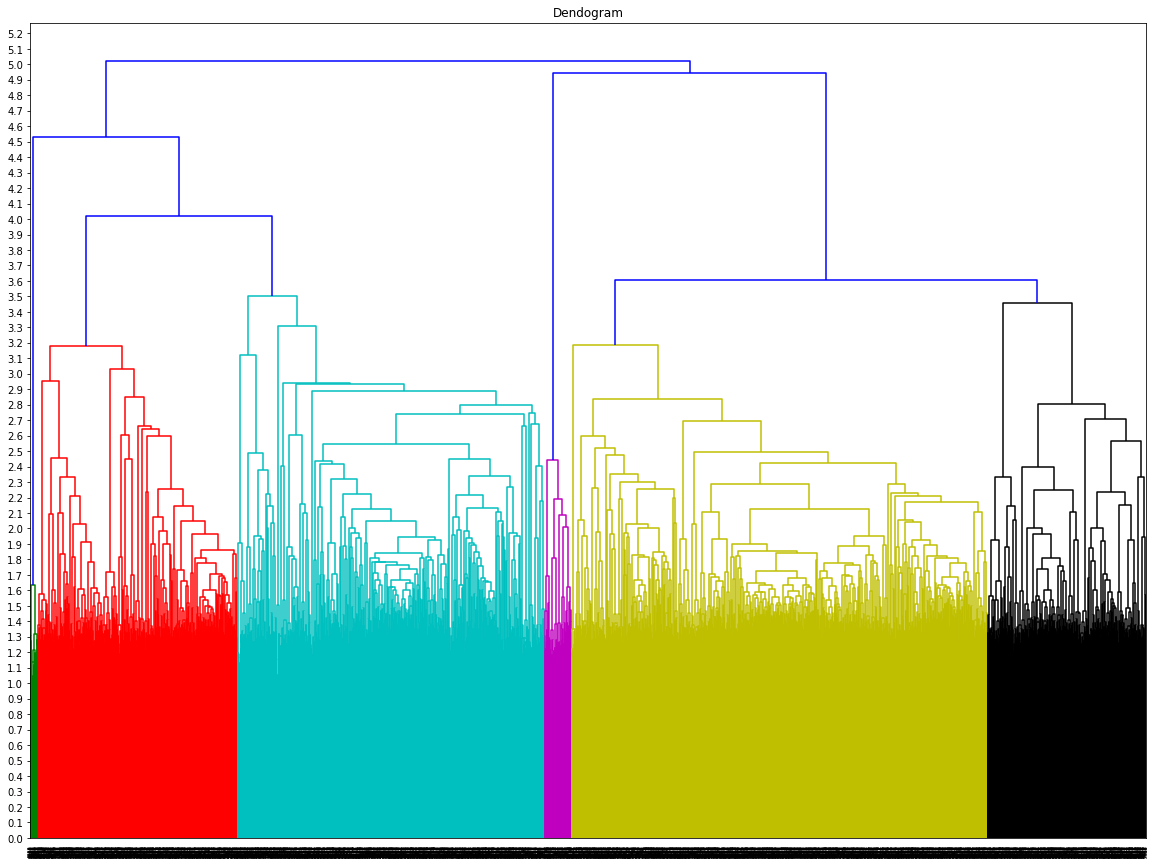

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Dendogram")
plt.yticks(np.arange(0, 6, 0.1))
dend = sch.dendrogram(sch.linkage(tfidf_norm10, method = 'ward'))

In [ ]:
clust_cent_list10 = get_cluster_centers(n_clusters = 6, data = tfidf_norm10)

In [ ]:
distances10 = predict_new_instances_simpl(predict_text10, clust_cent_list = clust_cent_list10, vectorizer = vectorizer10)

In [ ]:
calculate_correlations(distances10, np.log(predict_full10.box_of_rev))

******************* 
*******************
Pearson R:
(-0.21121571168446404, 0.0013699597307148756)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.21720913722456703, pvalue=0.0009879573051764835)


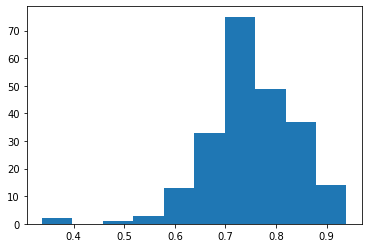

In [ ]:
plt.hist(distances10)
plt.show()

#### **1985-2010 to predict 2011 with PCA**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
train_full11 = movie_sub2[movie_sub2.year <2011]
predict_full11 = movie_sub2[movie_sub2.year == 2011]
train_text11 = train_full11.summary_lemmas.values
predict_text11 = predict_full11.summary_lemmas.values

In [ ]:
vectorizer11, linear_pca11, tfidf_dense11, train_linear_reduced11 = train_data_prep(train_text11)

In [ ]:
train_linear_norm11 = preprocessing.normalize(train_linear_reduced11)

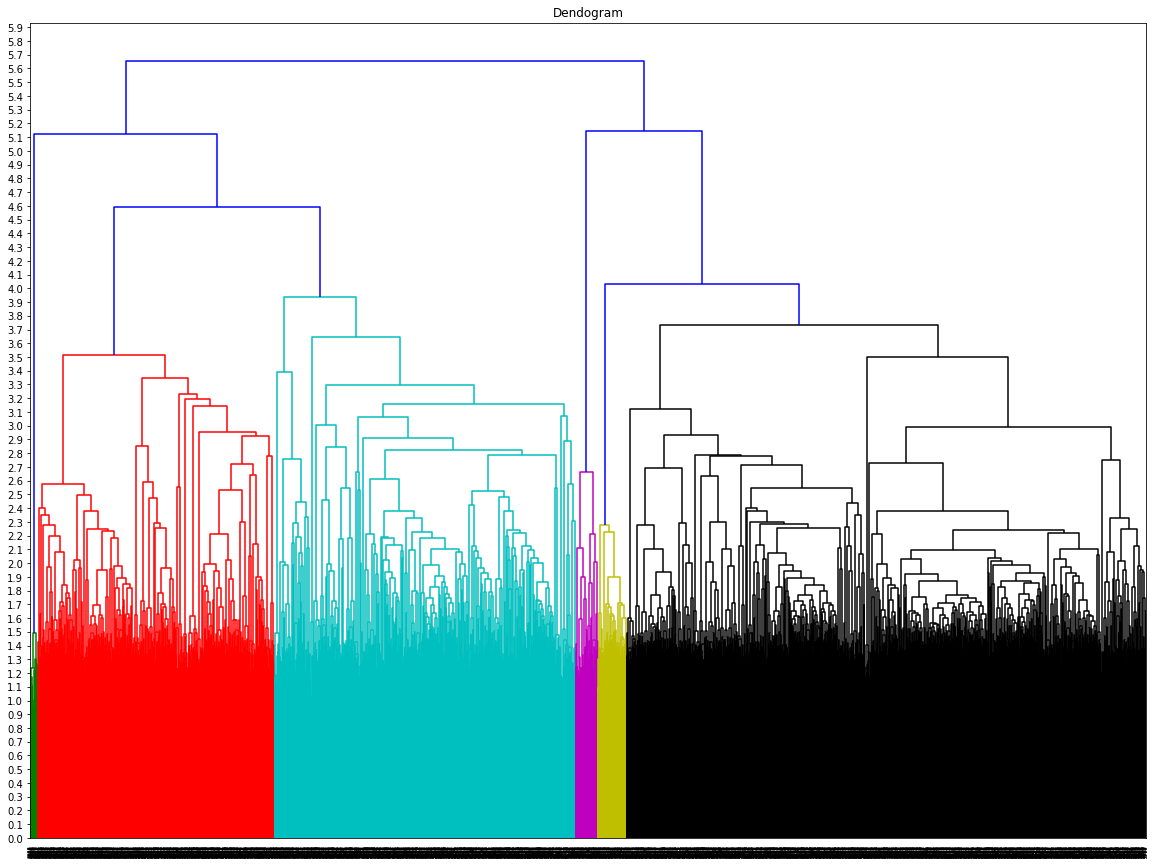

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Dendogram")
plt.yticks(np.arange(0, 6, 0.1))
dend = sch.dendrogram(sch.linkage(train_linear_norm11, method = 'ward'))

In [ ]:
clust_cent_list11 = get_cluster_centers(n_clusters = 6, data = train_linear_norm11)

In [ ]:
distances11 = predict_new_instances(predict_text11, clust_cent_list = clust_cent_list11, vectorizer = vectorizer11, pca_model = linear_pca11)

In [ ]:
calculate_correlations(distances11, predict_full11.box_of_rev)

******************* 
*******************
Pearson R:
(-0.130747679035202, 0.053898581148676315)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.07622480046841636, pvalue=0.26245540299407055)


#### **1985-2010 to predict 2011 FULL**

In [ ]:
movie_sub2 = pd.read_csv('/content/drive/MyDrive/movies2012data/movies1985_2011_text_clean.csv', index_col=False)

In [ ]:
train_full11 = movie_sub2[movie_sub2.year <2011]
predict_full11 = movie_sub2[movie_sub2.year == 2011]
train_text11 = train_full11.summary_lemmas.values
predict_text11 = predict_full11.summary_lemmas.values

In [ ]:
vectorizer11,tfidf_norm11 = train_data_prep_simpl(train_text11)

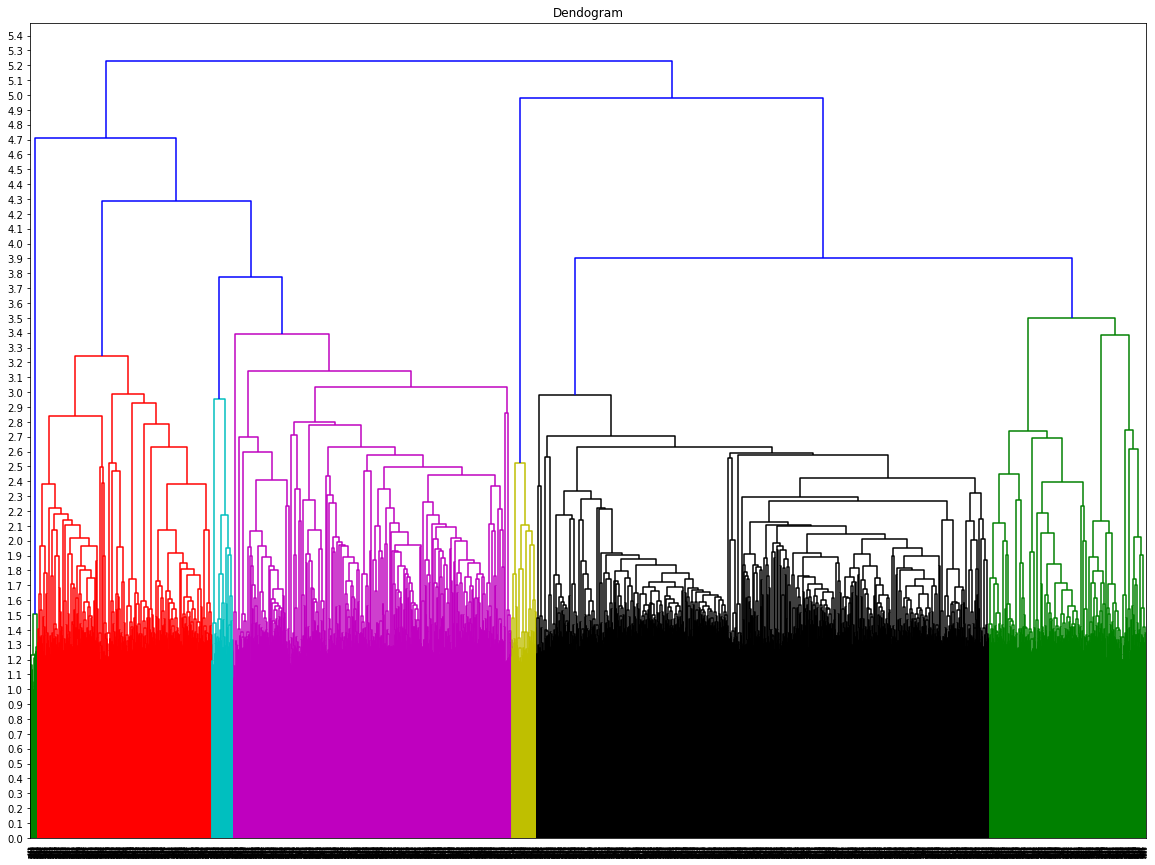

In [ ]:
plt.figure(figsize=(20,15))
plt.title("Dendogram")
plt.yticks(np.arange(0, 6, 0.1))
dend = sch.dendrogram(sch.linkage(tfidf_norm11, method = 'ward'))

In [ ]:
clust_cent_list11 = get_cluster_centers(n_clusters = 7, data = tfidf_norm11)

In [ ]:
distances11 = predict_new_instances_simpl(predict_text11, clust_cent_list = clust_cent_list11, vectorizer = vectorizer11)

In [ ]:
calculate_correlations(distances11, np.log(predict_full11.box_of_rev))

******************* 
*******************
Pearson R:
(-0.25931083559311147, 0.00010744780537461864)
******************* 
*******************
Spearman R:
SpearmanrResult(correlation=-0.24236897749365974, pvalue=0.0003038854414982887)


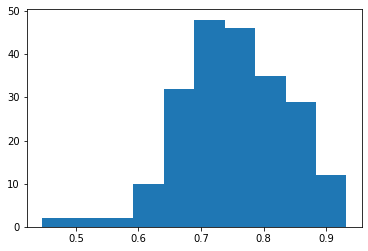

In [ ]:
plt.hist(distances11)
plt.show()

### **Topic Modeling**

In [ ]:
movie_sub = pd.read_csv('/content/drive/MyDrive/movies2012data/movies2012_text_clean.csv')

In [ ]:
text = movie_sub.summary_lemmas.values

In [ ]:
text_raw = movie_sub.summary.values

#### **Vectorizing the data**

**Using tf not tfisdf for LDA. See stack overlfow explanation in this below:**



*Since the StackOverflow link in the question comments seems broken, here is another reply that addresses the same question: https://stackoverflow.com/a/44789327/6470915*

*Direct quote:/

> *In fact, Blei (who developed LDA), points out in the introduction of the paper of 2003 (entitled "Latent Dirichlet Allocation") that LDA addresses the shortcomings of the TF-IDF model and leaves this approach behind. LSA is compeltely algebraic and generally (but not necessarily) uses a TF-IDF matrix, while LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. The weighting of TF-IDF is not necessary for this.*

*That sums it up on the high level. It would be interesting to understand more technically, why the model would perform more poorly if TF-IDF is used. Actually, there is another reply in the SO link which claims that LDA can be improved with TF-IDF.*


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer(analyzer = 'word', #default, can be changed to character n_grams (see docs)
                             min_df = 10, #frequencly of the word appearing is stricktly higher that 10
                             max_df = 0.9, #ignor terms that appear in 90% of the documents
                             stop_words = 'english', #just in case some were not caught earlier (probably redundant)
                             lowercase = True, #just in case some were not caught earlier (probably redundant)
                             token_pattern = '[A-Za-z]{3,}',
                             #max_features = 50000 #just in case
                             )

In [ ]:
data_vectorized = vectorizer.fit_transform(text)

**Sparcity check**

In [ ]:
#convert to dense
data_dense = data_vectorized.todense()

#calculate sparcity
print('Sparcuty: ', ((data_dense > 0).sum()/data_dense.size)*100, '%')

Sparcuty:  1.3723969618689034 %


In [ ]:
data_dense.shape

(7461, 10288)

In [ ]:
data_dense.shape

(7461, 10288)

#### **Building LDA with sklearn**

In [ ]:
#from sklearn.decomposition import TruncatedSVD

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

**Get number of Genres**

In [ ]:
fuller_data = pd.read_csv('/content/drive/MyDrive/movies2012data/movies2012_semi_prep.csv')

In [ ]:
from ast import literal_eval #needed to turn genre lists recorded as strings to lists

In [ ]:
genre_lists = fuller_data.genres.apply(lambda x: literal_eval(x)).tolist()
genre_flat = [g for sublist in genre_lists for g in sublist] # flattening
genre_np = np.array(genre_flat)
genre_unique = np.unique(genre_np)
print('Number of unique genres: ', len(genre_unique))

Number of unique genres:  305


In [ ]:
genre_unique

array(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy', 'Airplanes and airports',
       'Albino bias', 'Alien Film', 'Alien invasion', 'Americana',
       'Animal Picture', 'Animals', 'Animated Musical',
       'Animated cartoon', 'Animation', 'Anime', 'Anthology', 'Anti-war',
       'Anti-war film', 'Apocalyptic and post-apocalyptic fiction',
       'Archaeology', 'Archives and records', 'Art film', 'Auto racing',
       'Avant-garde', 'B-Western', 'B-movie', 'Backstage Musical',
       'Baseball', 'Beach Film', 'Biker Film', 'Biographical film',
       'Biography', 'Biopic [feature]', 'Black comedy', 'Black-and-white',
       'Blaxploitation', 'Bloopers & Candid Camera', 'Bollywood',
       'Boxing', 'Breakdance', 'British Empire Film', 'British New Wave',
       'Buddy cop', 'Buddy film', 'Business', 'Camp', 'Caper story',
       'Cavalry Film', 'Chase Movie', '

Makes no sense to use number of genres as number of topics: too many

**Start with first LDA**

In [ ]:
lda1 = LatentDirichletAllocation(n_components = 8, #start with the smallest n based on agglomerative clustering
                                 max_iter = 10, #IS DEFAULT The maximum number of passes over the training data (aka epochs)
                                 learning_method = 'online', #DEFAULT = 'batch' online is faster than default 'batch' for bigger data
                                 random_state = 42,
                                 batch_size = 128, #IS DEFAULT, Number of documents to use in each EM iteration. Only used in online learning.
                                 evaluate_every = -1, #IS DEFAULT How often to evaluate perplexity.  (-1 = not at all) - increases run time
                                 n_jobs = -1) #IS DEFAULT = None; context. -1 means using all processors. 

In [ ]:
lda1_output = lda1.fit_transform(data_vectorized)
print(lda1) # model attributes

LatentDirichletAllocation(learning_method='online', n_components=8, n_jobs=-1,
                          random_state=42)


**First model diagnistic**

In [ ]:
# Log Likelihood: the higher the better:
print('Log Likelyhood: ', lda1.score(data_vectorized))

#Preplexity: the lower the better; Perplexity = exp(-1. * log-likelihood per word)
print('Preplexity: ', lda1.perplexity(data_vectorized))

#see Model Params:
print(lda1.get_params())

Log Likelyhood:  -10962668.236118736
Preplexity:  2994.6501813999116
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 8, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


##### **GridSearch on LDA**

In [ ]:
search_params = {'n_components': [8, 12, 13, 20, 23, 25, 26, 29, 34, 35, 37, 41, 47], #all options considered in previous clustering
                 'learning_method': ['online'], #to make it faster
                 'learning_decay': [.5, .7, .9] #DEFAULT = .7 a parameter that controls learning rate in the online learning method. 
                 }

In [ ]:
#initiate the model
lda = LatentDirichletAllocation()

#initiate grid search
model_grid = GridSearchCV(lda, param_grid = search_params)

# dot he grid searcg

model_grid.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['online'],
                         'n_components': [8, 12, 13, 20, 23, 25, 26, 29, 34, 35,
                                          37, 41, 47]})

In [ ]:
#best model

best_lda = model_grid.best_estimator_

#model params
print('Best Model Params: ', model_grid.best_params_)

#log likelohood score
print('Best Log Likelihood: ', model_grid.best_score_)


Best Model Params:  {'learning_decay': 0.5, 'learning_method': 'online', 'n_components': 8}
Best Log Likelihood:  -2282786.498607546


**Plot the results of Grid Search**

In [ ]:
model_grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_decay', 'param_learning_method', 'param_n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
mean_test_score = model_grid.cv_results_['mean_test_score']
param_learning_decay = model_grid.cv_results_['param_learning_decay'].data
param_n_components = model_grid.cv_results_['param_n_components'].data

grid_search_score_df = pd.DataFrame({'mean_test_score': mean_test_score,
                                     'param_learning_decay': param_learning_decay,
                                     'param_n_components': param_n_components})

grid_search_score_df.head()

,mean_test_score,param_learning_decay,param_n_components
0,-2.282786e+06,0.5,8
1,-2.295200e+06,0.5,12
2,-2.299317e+06,0.5,13
3,-2.309734e+06,0.5,20
4,-2.315028e+06,0.5,23


In [ ]:
learning_decay5 = grid_search_score_df[grid_search_score_df.param_learning_decay==0.5]
learning_decay7 = grid_search_score_df[grid_search_score_df.param_learning_decay==0.7]
learning_decay9 = grid_search_score_df[grid_search_score_df.param_learning_decay==0.9]

In [ ]:
n_topics = [8, 12, 13, 20, 23, 25, 26, 29, 34, 35, 37, 41, 47]

In [ ]:
import matplotlib.pyplot as plt

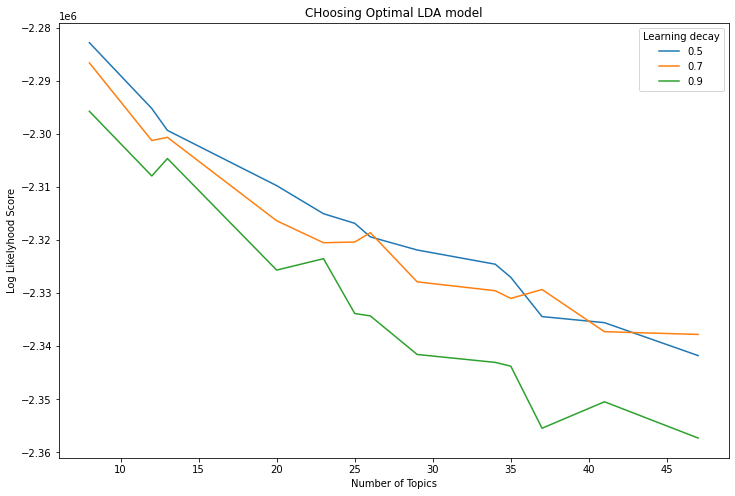

In [ ]:
#plotting
plt.figure(figsize = (12,8))
plt.plot(n_topics, learning_decay5.mean_test_score, label = '0.5')
plt.plot(n_topics, learning_decay7.mean_test_score, label = '0.7')
plt.plot(n_topics, learning_decay9.mean_test_score, label = '0.9')
plt.title('CHoosing Optimal LDA model')
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelyhood Score') #the higher the better
plt.legend(title = 'Learning decay', loc = 'best')
plt.show()

##### **Calculating Topic Dominance for each Doc**

In [ ]:
#create document-topic matrix
lda_output = best_lda.transform(data_vectorized)

#get topics (col names)
topicnames = ['Topic' + str(i) for i in range(best_lda.n_components)] 

#index for document number
docnames = ['Doc' + str(i) for i in range(len(text))]

#turn into pandas df
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topicnames, index = docnames)

#get dominant topic for each doc
dominant_topic = np.argmax(df_document_topic.values, axis = 1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
Doc0,0.19,0.02,0.22,0.09,0.34,0.03,0.0,0.11,4
Doc1,0.27,0.13,0.17,0.34,0.08,0.00,0.0,0.00,3
Doc2,0.00,0.00,0.00,0.70,0.07,0.21,0.0,0.02,3
Doc3,0.00,0.40,0.00,0.29,0.00,0.08,0.0,0.23,1
Doc4,0.03,0.45,0.35,0.06,0.04,0.04,0.0,0.03,1


In [ ]:
#saving
df_document_topic.to_csv('df_document_topic.csv')

!cp df_document_topic.csv "/content/drive/MyDrive/movies2012data"

**Topic Distribution Across Documents (for dominant topic)**

In [ ]:
topic_dist = df_document_topic.groupby(['dominant_topic']).size().reset_index(name = 'counts_dominant')
topic_dist.sort_values(by = ['counts_dominant'], ascending = False, inplace = True)
topic_dist.head(len(topic_dist))

,dominant_topic,counts_dominant
3,3,2993
0,0,1330
1,1,869
5,5,704
2,2,588
4,4,499
6,6,239
7,7,239


##### **Visualizing**

In [ ]:
lda_best = LatentDirichletAllocation(n_components = 8, #start with the smallest n based on agglomerative clustering
                                 max_iter = 10, #IS DEFAULT The maximum number of passes over the training data (aka epochs)
                                 learning_method = 'online', #DEFAULT = 'batch' online is faster than default 'batch' for bigger data
                                 learning_decay = 0.5,
                                 random_state = 42,
                                 batch_size = 128, #IS DEFAULT, Number of documents to use in each EM iteration. Only used in online learning.
                                 evaluate_every = -1, #IS DEFAULT How often to evaluate perplexity.  (-1 = not at all) - increases run time
                                 n_jobs = -1) #IS DEFAULT = None; context. -1 means using all processors. 

In [ ]:
lda2_output = lda_best.fit_transform(data_vectorized)
print(lda_best) # model attributes

In [ ]:
!pip install pyLDAvis #!!!! need to reaload afterwards!!

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
pyLDAvis.sklearn.prepare(lda_best, data_vectorized, vectorizer)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.083897 -0.011715       1        1  20.653858
7      0.132636 -0.128603       2        1  19.141886
6      0.018494  0.112542       3        1  14.037542
2     -0.022698  0.176419       4        1  12.369580
1      0.161783  0.071026       5        1  10.909854
5      0.001271  0.055898       6        1  10.298582
0      0.006697 -0.249211       7        1   9.107871
3     -0.382080 -0.026356       8        1   3.480827, topic_info=         Term         Freq        Total Category  logprob  loglift
8031   school  2921.000000  2921.000000  Default  30.0000  30.0000
4514    house  4415.000000  4415.000000  Default  29.0000  29.0000
5485     love  4141.000000  4141.000000  Default  28.0000  28.0000
9452    train  1449.000000  1449.000000  Default  27.0000  27.0000
8258     ship  1409.000000  1409.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
8731  station   280.858554  1034.857386   Topic8  -5.1342   2.0537
5723      men   316.089467  3085.067784   Topic8  -5.0161   1.0796
3757      fly   242.234460   719.358622   Topic8  -5.2822   2.2694
6207  officer   266.109114  1616.395900   Topic8  -5.1882   1.5539
6271    order   254.561376  2797.411256   Topic8  -5.2325   0.9610

[614 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
17         3  0.019656    aboard
17         4  0.067391    aboard
17         8  0.912584    aboard
20         1  0.991717  abortion
110        1  0.073653     actor
...      ...       ...       ...
10277      4  0.003814     young
10277      5  0.193734     young
10277      6  0.104113     young
10277      7  0.001144     young
10284      4  0.996880    zombie

[1365 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 7, 3, 2, 6, 1, 4])

##### **Getting Topic Key Words**

In [ ]:
# Topic-keyword matrix

df_topic_keywords = pd.DataFrame(lda_best.components_)

#assign column names & index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = ['Topic' + str(i) for i in range(lda_best.n_components)] 

In [ ]:
df_topic_keywords.head(8)

,aback,abandd,abandon,abandoned,abandoning,abandonment,abdomen,abduct,abducted,abducting,abduction,abductor,abducts,ability,ablaze,able,abnormal,aboard,abort,aborted,abortion,abrasive,abroad,abruptly,absence,absent,absolute,absolutely,absorb,absorbed,absorbing,absorbs,absurd,abuse,abused,abusing,abusive,academic,academy,accent,...,wrestler,wrestling,wrist,wristwatch,write,writer,writes,writing,written,wrong,wrongdoing,wronged,wrongfully,wrongly,wrote,wwwimdbcom,yacht,yank,yard,year,yearbook,yearning,yell,yelling,yellow,yes,yield,yoga,york,young,younger,youngest,youngster,youth,youthful,zip,zombie,zone,zoo,zoom
Topic0,0.125405,0.125249,0.125255,0.125201,0.125328,5.310605,0.125073,0.125154,0.125220,0.125408,0.125157,0.125192,0.125386,136.085065,0.125084,122.115624,0.125906,0.125073,0.125202,0.125628,0.125301,0.125292,0.125200,0.125207,43.413143,0.125289,0.125246,0.125178,0.125136,19.206295,0.125074,0.125060,0.125263,31.325748,10.371214,0.125344,0.125319,58.492291,55.228201,0.125383,...,0.125801,55.798861,0.125307,0.125277,30.813905,0.125209,0.125197,14.800928,0.125313,34.321058,0.125202,0.125118,10.376710,0.125156,0.125238,0.125194,0.125182,0.125361,8.173955,111.668869,0.125366,8.695007,0.125224,0.125214,0.125278,0.125268,0.125517,0.125380,3.705467,3.187618,19.980169,47.107993,0.125173,43.332940,0.125266,0.125353,0.125048,17.113640,1.737577,0.125035
Topic1,0.125145,41.517909,0.125194,54.128223,0.125202,0.125356,0.125289,0.125211,22.931330,0.126174,23.870392,9.959600,0.125383,54.841618,0.125419,112.386751,0.125592,0.125118,0.125229,0.125969,0.125244,0.125211,0.125161,32.414188,38.931646,0.451786,9.779989,0.125928,0.125167,0.125211,0.125182,0.125393,0.125267,45.595736,0.125516,16.835138,45.861488,0.125177,0.125163,0.125134,...,40.640763,0.125144,71.460390,0.125657,8.053729,0.125204,9.736317,28.350466,98.738558,38.270860,0.125316,0.125282,0.126314,0.125088,19.798598,0.125582,0.125135,0.125454,0.125273,118.994182,19.681183,0.125214,33.848977,14.696541,17.882386,0.125317,0.125185,0.125070,0.125197,514.519373,81.629340,52.600814,0.125117,11.611835,0.125136,0.125213,0.125124,0.125180,0.125097,0.125187
Topic2,0.125203,119.012218,49.576773,139.657068,13.866843,0.125413,29.830876,10.508400,38.738501,7.933745,0.125333,0.125147,25.303297,76.284878,21.132201,247.760758,0.125302,23.936810,0.125573,0.125255,0.125151,0.125064,0.125128,9.644244,0.125227,10.978295,0.125286,0.125453,0.125445,16.501085,0.125241,0.125747,0.125075,0.125236,12.673237,0.125201,0.125125,0.125154,0.125142,0.125103,...,0.125358,0.125193,17.322738,0.125728,0.125142,0.125081,0.125170,0.125150,0.125242,45.126038,0.125185,3.142744,0.125407,0.125245,0.125154,0.125130,0.125283,10.803017,21.534896,4.224779,0.125087,0.125138,12.513551,0.125201,26.043527,0.125129,0.125390,0.125070,0.125414,10.039645,0.125394,0.125296,0.125231,0.125220,0.125163,5.412436,187.823655,30.685482,97.577398,11.418248
Topic3,0.125145,0.125278,0.125241,0.125258,9.479461,0.125079,0.125223,0.125188,0.125148,0.125401,0.125083,0.125067,0.125244,0.125160,0.125371,67.244321,0.125184,327.807240,0.125363,0.125256,0.125083,0.125047,0.125119,0.125159,0.125219,0.125295,0.125022,0.125117,0.125126,0.125145,0.125059,0.125072,0.125182,0.125225,0.125132,0.125130,0.125124,0.125148,0.125184,0.125101,...,0.125473,0.125157,0.125140,0.125187,0.125304,0.125091,0.125197,0.125096,0.125186,0.125230,0.125174,0.125082,0.126072,0.125183,0.125221,0.125126,0.125439,0.125115,0.125196,49.687776,0.125018,0.125292,0.125306,0.125157,0.125424,0.125367,0.125556,0.125045,0.125255,0.125245,0.125225,0.125308,0.125132,0.125158,0.125220,0.125278,0.125037,0.125484,0.125123,0.125050
Topic4,21.981240,59.093365,15.563930,0.125219,0.125215,0.125315,0.125231,0.125222,0.125177,0.126183,0.125101,0.125167,0.125491,0.125195,0.125245,117.649378,0.126418,0.125133,0.125186,0.125681,147.136166,6.008593,0.125222,33.319002,0.125339,0.125249,0.125167,0.125199,0.125070,0.125325,0.125023,0.125062,0.125253,0.125311,0.125227,10.918921,16.222549,0.125094,0.125178,0.1252

Maybe stemming is a better option here: lemmatization leaves too manu options (see the fist few columns)

In [ ]:
#saving
df_topic_keywords.to_csv('df_topic_keywords.csv')

!cp df_topic_keywords.csv "/content/drive/MyDrive/movies2012data"

##### **Get top words per topic**

In [ ]:
#transposing the df
df_topic_keywords_tr = df_topic_keywords.T

df_topic_keywords_tr.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7
aback,0.125405,0.125145,0.125203,0.125145,21.981240,0.125311,0.125170,0.125383
abandd,0.125249,41.517909,119.012218,0.125278,59.093365,0.125264,12.567530,0.125248
abandon,0.125255,0.125194,49.576773,0.125241,15.563930,61.079937,17.636205,143.225151
abandoned,0.125201,54.128223,139.657068,0.125258,0.125219,6.823763,0.158804,76.468322
abandoning,0.125328,0.125202,13.866843,9.479461,0.125215,7.860083,0.125268,45.654018


In [ ]:
df_topic_keywords_tr.index[:5]

Index(['aback', 'abandd', 'abandon', 'abandoned', 'abandoning'], dtype='object')

In [ ]:
topics = ['Topic' + str(i) for i in range(lda_best.n_components)] 

for topic in topics:
  print(topic)
  df_ordered = df_topic_keywords_tr.sort_values(by = [topic], ascending = False)
  print(df_ordered.index[:15])

Topic0
Index(['school', 'film', 'game', 'team', 'student', 'play', 'band', 'win',
       'high', 'new', 'friend', 'end', 'song', 'class', 'teacher'],
      dtype='object')
Topic1
Index(['house', 'father', 'tell', 'body', 'room', 'mother', 'child', 'death',
       'boy', 'begin', 'man', 'girl', 'home', 'town', 'dead'],
      dtype='object')
Topic2
Index(['escape', 'kill', 'group', 'head', 'attempt', 'attack', 'dog', 'human',
       'try', 'inside', 'begin', 'fall', 'killed', 'run', 'alien'],
      dtype='object')
Topic3
Index(['ship', 'train', 'crew', 'plane', 'town', 'race', 'board', 'pilot',
       'boat', 'mission', 'captain', 'passenger', 'water', 'horse', 'aboard'],
      dtype='object')
Topic4
Index(['tell', 'car', 'friend', 'home', 'house', 'make', 'try', 'money',
       'asks', 'leaf', 'come', 'run', 'meet', 'say', 'party'],
      dtype='object')
Topic5
Index(['soldier', 'return', 'war', 'fight', 'battle', 'order', 'power', 'army',
       'attack', 'city', 'help', 'village', 'wo

##### **Grid search on smaller number of topics**

Proposes the smallest, which probably means this is not the best approach (seems like the same isse like with gaussian mixtures)

In [ ]:
search_params = {'n_components': [2,3,5,6,8,9], #all options considered in previous clustering
                 'learning_method': ['online'], #to make it faster
                 'learning_decay': [.5, .7, .9] #DEFAULT = .7 a parameter that controls learning rate in the online learning method. 
                 }

#initiate the model
lda = LatentDirichletAllocation()

#initiate grid search
model_grid2 = GridSearchCV(lda, param_grid = search_params)

# dot he grid searcg

model_grid2.fit(data_vectorized)  


#best model

best_lda = model_grid2.best_estimator_

#model params
print('Best Model Params: ', model_grid2.best_params_)

#log likelohood score
print('Best Log Likelihood: ', model_grid2.best_score_)


Best Model Params:  {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 2}
Best Log Likelihood:  -2238782.04865709


##### **Calculating distances**

In [ ]:
movie_sub = pd.read_csv('/content/drive/MyDrive/movies2012data/movies2012_text_clean.csv')

In [ ]:
doc_top_df = pd.read_csv('/content/drive/MyDrive/movies2012data/df_document_topic.csv')

*Explore*

In [ ]:
movie_sub.shape

(7461, 19)

In [ ]:
doc_top_df.shape

(7461, 10)

In [ ]:
doc_top_df.iloc[:,1:9].mean(axis = 0) # average topic distribution

Topic0    0.139430
Topic1    0.137191
Topic2    0.111108
Topic3    0.310772
Topic4    0.087315
Topic5    0.109334
Topic6    0.048538
Topic7    0.053481
dtype: float64

In [ ]:
list(doc_top_df.iloc[:,1:9].mean(axis = 0))

[0.1394303712639039,
 0.13719072510387215,
 0.11110843050529212,
 0.3107720144752708,
 0.08731537327435814,
 0.10933386945449504,
 0.04853772952687221,
 0.05348076665326287]

In [ ]:
doc_top_df.iloc[:,1:9]

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7
0,0.19,0.02,0.22,0.09,0.34,0.03,0.00,0.11
1,0.27,0.13,0.17,0.34,0.08,0.00,0.00,0.00
2,0.00,0.00,0.00,0.70,0.07,0.21,0.00,0.02
3,0.00,0.40,0.00,0.29,0.00,0.08,0.00,0.23
4,0.03,0.45,0.35,0.06,0.04,0.04,0.00,0.03
...,...,...,...,...,...,...,...,...
7456,0.08,0.74,0.03,0.12,0.02,0.00,0.00,0.01
7457,0.42,0.14,0.14,0.10,0.00,0.14,0.00,0.06
7458,0.75,0.00,0.06,0.00,0.08,0.04,0.00,0.07
7459,0.00,0.00,0.06,0.88,0.00,0.00,0.06,0.00


*Function*

In [ ]:
# get matrix with only topic columns
only_matrix = doc_top_df.iloc[:,1:9].copy()

In [ ]:
def get_topical_distance(df):
  topic_names = df.columns #get topic names
  topic_averages = list(df.mean(axis = 0))#get topic averages

  distances_df = pd.DataFrame()#creating empty df
  for i in range(len(topic_averages)): #for each topic index
    col_name = 'dist_' + str(topic_names[i]) #create column name for df
    distances = [] #list to put tidtances 
    for item in df[topic_names[i]]: #for each item in df column
      distances.append(abs(item - topic_averages[i])/(item + topic_averages[i] + 0.0001)) #calculate distance (used Ireland & Pennebaker 2010 for formula)

    distances_df[col_name] =  distances #append column to df

  return list(distances_df.mean(axis = 1)) #get the distance measure


In [ ]:
movie_sub['LDAsklearn_8'] = get_topical_distance(only_matrix)

In [ ]:
movie_sub.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], inplace = True)

In [ ]:
#save
movie_sub.to_csv('movies2012_text_clean.csv')
!cp movies2012_text_clean.csv "/content/drive/MyDrive/movies2012data"

*Getting Correlations*

In [ ]:
scipy.stats.pearsonr(np.log(movie_sub.box_of_rev), movie_sub.LDAsklearn_8)

(-0.19067812683001806, 4.979492415777572e-62)

In [ ]:
scipy.stats.spearmanr(np.log(movie_sub.box_of_rev), movie_sub.LDAsklearn_8)

SpearmanrResult(correlation=-0.19694532636287243, pvalue=3.9342578321007965e-66)

#### **Building LDA with Gensim**

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [ ]:
from gensim.utils import simple_preprocess

##### **Preparing the corpus first**

For gensim the data needs to be converted into a list of lists: each document should be tocenized (each word is a new element in a list). 

In [ ]:
tokenized_text = []
for t in text:
  tokenized_text.append(gensim.utils.simple_preprocess(t, deacc = True, min_len = 3)) # deacc=True removes punctuation; min_len=3 sets minimum length of a tocen to 3 characters

In [ ]:
len(text)

7461

In [ ]:
len(tokenized_text)

7461

In [ ]:
print(tokenized_text[0])

['nation', 'consists', 'wealthy', 'poorer', 'district', 'punishment', 'past', 'rebellion', 'district', 'must', 'provide', 'boy', 'girl', 'age', 'selected', 'lottery', 'tribute', 'must', 'fight', 'death', 'arena', 'sole', 'survivor', 'rewarded', 'fame', 'wealth', 'reaping', 'old', 'chosen', 'older', 'sister', 'volunteer', 'take', 'place', 'peeta', 'mellark', 'baker', 'son', 'gave', 'bread', 'starving', 'tribute', 'peeta', 'taken', 'accompanied', 'frequently', 'drunk', 'mentor', 'past', 'victor', 'abernathy', 'warns', 'tribute', 'train', 'intensively', 'special', 'academy', 'almost', 'always', 'win', 'interview', 'peeta', 'unexpectedly', 'reveals', 'love', 'outraged', 'believing', 'ploy', 'gain', 'audience', 'support', 'sponsor', 'may', 'provide', 'game', 'gift', 'food', 'medicine', 'tool', 'however', 'discovers', 'peeta', 'meant', 'said', 'televised', 'game', 'begin', 'tribute', 'killed', 'minute', 'barely', 'survives', 'ignoring', 'advice', 'run', 'away', 'melee', 'tempting', 'supply',

Each text should not be more than 10 000 tokens. That's where the cut-off is.
Checking:

In [ ]:
count = 0
for t in tokenized_text:
  count = count +1
  if len(t)>10000:
    print('Number of doc longer than 10 000 is '+str(count))  

In [ ]:
#creating dictionary
id2word = corpora.Dictionary(tokenized_text) #creates gensim corpora object

#create corpus
texts = tokenized_text

#TermDocument Frequency
corpus = [id2word.doc2bow(txt) for txt in texts]


In [ ]:
print(id2word)

Dictionary(38729 unique tokens: ['abernathy', 'able', 'academy', 'accompanied', 'advice']...)


In [ ]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 3), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 3), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 3), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 3), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 2),

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

> it in creation of corpus some words seem to be dropped. For example: tokenized_text[0] has 336 words, while the corpus alternative has only 259

##### **Topic Model with Gensim**

**First model with 8 topics**

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 8,
                                            random_state = 42,
                                            update_every = 1, #Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.
                                            chunksize = 128, #number of docus to use in each training chunk (picked 128 just the same as in sklearn)
                                            passes = 10, #Number of passes through the corpus during training
                                            alpha = 'auto', #A-priori belief on document-topic distribution
                                            per_word_topics = True)

In [ ]:
#Print keywords for 
for topic in lda_model.print_topics():
  print(topic)

(0, '0.014*"plane" + 0.010*"president" + 0.009*"flight" + 0.008*"board" + 0.008*"company" + 0.007*"vampire" + 0.007*"pilot" + 0.006*"crew" + 0.005*"passenger" + 0.005*"chief"')
(1, '0.018*"ship" + 0.012*"water" + 0.010*"dog" + 0.010*"island" + 0.009*"boat" + 0.008*"animal" + 0.007*"crew" + 0.006*"creature" + 0.005*"cave" + 0.005*"find"')
(2, '0.009*"escape" + 0.008*"power" + 0.006*"attempt" + 0.006*"team" + 0.006*"world" + 0.006*"find" + 0.005*"using" + 0.005*"human" + 0.005*"agent" + 0.005*"control"')
(3, '0.009*"father" + 0.009*"friend" + 0.009*"tell" + 0.009*"life" + 0.008*"get" + 0.007*"love" + 0.007*"find" + 0.007*"home" + 0.007*"take" + 0.007*"mother"')
(4, '0.011*"police" + 0.011*"death" + 0.008*"man" + 0.008*"murder" + 0.007*"wife" + 0.006*"drug" + 0.005*"suicide" + 0.005*"prison" + 0.005*"agent" + 0.005*"apartment"')
(5, '0.022*"film" + 0.013*"school" + 0.010*"play" + 0.009*"band" + 0.009*"show" + 0.008*"game" + 0.008*"win" + 0.008*"student" + 0.007*"team" + 0.005*"high"')
(6,

In [ ]:
print('\nPreplexity: ', lda_model.log_perplexity(corpus)) #how good the model is (the lower the better)

#Coherence:
coherence_model_lda = CoherenceModel(model = lda_model, 
                                     texts = tokenized_text, 
                                     dictionary=id2word, 
                                     coherence = 'c_v' #Coherence measure to be use, 'u_mass',  is the fastest WARNING: different formulas for coherence calculation! based on stack exchange discussion some reccomend vc, other say use with caution
                                     )
coherence_lda = coherence_model_lda.get_coherence()
print('\Coherence Score: ', coherence_lda)



Preplexity:  -8.42469343374233
\Coherence Score:  0.40440325536711585


In [ ]:
#Coherence:
coherence_model_lda = CoherenceModel(model = lda_model, 
                                     corpus = corpus, 
                                     dictionary=id2word, 
                                     coherence = 'u_mass' #Coherence measure to be use, 'u_mass',  is the fastest 
                                     )
coherence_lda = coherence_model_lda.get_coherence()
print('\Coherence Score: ', coherence_lda)

\Coherence Score:  -1.988657016599948


In [ ]:
#Coherence:
coherence_model_lda = CoherenceModel(model = lda_model, 
                                     texts = tokenized_text, 
                                     dictionary=id2word, 
                                     coherence = 'u_mass' #Coherence measure to be use, 'u_mass',  is the fastest WARNING: different formulas for coherence calculation! based on stack exchange discussion some reccomend vc, other say use with caution
                                     )
coherence_lda = coherence_model_lda.get_coherence()
print('\Coherence Score: ', coherence_lda)


\Coherence Score:  -1.988657016599948


##### **Searching for the optimal model**

**Searching for the best number of topics with u_mass**

https://stats.stackexchange.com/questions/375062/how-does-topic-coherence-score-in-lda-intuitively-makes-sense
The coherence score is for assessing the quality of the learned topics.

For one topic, the words i,j
being scored in ∑i<jScore(wi,wj)

have the highest probability of occurring for that topic. You need to specify how many words in the topic to consider for the overall score.

For the "UMass" measure, the numerator D(wi,wj)
is the number of documents in which words wi and wj appear together. 1 is added to this term because we are taking logs and we need to avoid taking log of 0 when the two words never appear together. The denominator is the number of documents D(wi) appears in. So the score is higher if wi and wj appear together in documents a lot relative to how often wi

alone appears in documents. This makes sense as a measure of topic coherence, since if two words in a topic really belong together you would expect them to show up together a lot. The denominator is just adjusting for the document frequency of the words you are considering, so that words like "the" don't get an artificially high score.

You could use the topic coherence scores, CS(t)
for t=1,…,K, to determine the optimal number K∗ of topics by finding argmaxK1K∑Kt=1CS(t). That is take the average topic coherence score for various settings of K and see which gives the highest average coherence.

In [ ]:
def compute_coherence_values(dictionary, corpus, text, n_topics, coherence_par):
  coherence_values = []
  model_list = []

  for n in n_topics:
    model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                              id2word = dictionary,
                                              num_topics = n,
                                              random_state = 42,
                                              update_every = 1, #Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.
                                              chunksize = 128, #number of docus to use in each training chunk (picked 128 just the same as in sklearn)
                                              passes = 10, #Number of passes through the corpus during training
                                              alpha = 'auto', #A-priori belief on document-topic distribution
                                              per_word_topics = True)
    model_list.append(model)
    coherencemodel = CoherenceModel(model = model, 
                                    texts = text, 
                                    dictionary=dictionary, 
                                    coherence = coherence_par #Coherence measure to be use, 'u_mass',  is the fastest 
                                    )
    coherence_values.append(coherencemodel.get_coherence())
  return model_list, coherence_values

In [ ]:
n_topics = [2, 3, 5, 6, 8, 12, 13, 20, 23, 25, 26, 29, 34, 35, 37, 41, 47]
model_list, coherence_values = compute_coherence_values(dictionary = id2word, corpus = corpus, text = tokenized_text, n_topics = n_topics, coherence_par = 'u_mass')

In [ ]:
coherence_values

[-0.9738076378308185,
 -1.0251379725063012,
 -1.3227866491939724,
 -1.2979407347777638,
 -1.988657016599948,
 -2.76674908480472,
 -2.44779400550867,
 -3.5536628370622743,
 -3.9214872243636036,
 -3.899997156941426,
 -4.667631312160538,
 -3.99414757869266,
 -6.086603109220191,
 -5.412157033662751,
 -4.690282505654916,
 -5.530387087386683,
 -6.197491138748244]

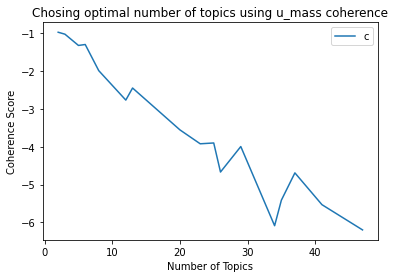

In [ ]:
plt.plot(n_topics, coherence_values)
plt.title('Chosing optimal number of topics using u_mass coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'), loc = 'best')
plt.show()

**Searching for the best number of topics with c_v**

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary = id2word, corpus = corpus, text = tokenized_text, n_topics = n_topics, coherence_par = 'c_v')

In [ ]:
coherence_values

[0.3453612039539308,
 0.33434631658514263,
 0.38719713527385297,
 0.37657076816264423,
 0.40440325536711585,
 0.4337499759346836,
 0.4439878706406729,
 0.45914923773711624,
 0.44013286313043787,
 0.4411121731114398,
 0.45509728443661907,
 0.4532712932130289,
 0.4569461628522189,
 0.43424324725238067,
 0.4492408311320378,
 0.44305032269740857,
 0.4462513714490115]

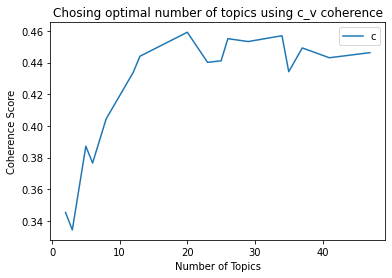

In [ ]:
plt.plot(n_topics, coherence_values)
plt.title('Chosing optimal number of topics using c_v coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'), loc = 'best')
plt.show()

In [ ]:
coherence_df = pd.DataFrame({'n_topics': n_topics,
                             'coherence': coherence_values})


In [ ]:
coherence_df

,n_topics,coherence
0,2,0.345361
1,3,0.334346
2,5,0.387197
3,6,0.376571
4,8,0.404403
5,12,0.433750
6,13,0.443988
7,20,0.459149
8,23,0.440133
9,25,0.441112


In [ ]:
improvement = [0]

for i in range(len(coherence_df.coherence)):
  if i > 0:
    imr = coherence_df.coherence[i]/coherence_df.coherence[i-1] - 1
    improvement.append(np.round(imr, 2))


In [ ]:
coherence_df['coherence_improvement'] = improvement

In [ ]:
coherence_df

,n_topics,coherence,coherence_improvement
0,2,0.345361,0.00
1,3,0.334346,-0.03
2,5,0.387197,0.16
3,6,0.376571,-0.03
4,8,0.404403,0.07
5,12,0.433750,0.07
6,13,0.443988,0.02
7,20,0.459149,0.03
8,23,0.440133,-0.04
9,25,0.441112,0.00


In [ ]:
print('8 vs 20 topics coherence improvement: ' + str(np.round(((0.459149/0.404403 - 1)*100),1)) + '%')

8 vs 20 topics coherence improvement: 13.5%


##### **Trainin the two optimal models**

**Model with 8 topics**

In [ ]:
lda_model8 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 8,
                                            random_state = 42,
                                            update_every = 1, #Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.
                                            chunksize = 128, #number of docus to use in each training chunk (picked 128 just the same as in sklearn)
                                            passes = 10, #Number of passes through the corpus during training
                                            alpha = 'auto', #A-priori belief on document-topic distribution
                                            per_word_topics = True)

In [ ]:
lda_model8[corpus[0]][0] # topic distribution for text 1

[(0, 0.044837523),
 (1, 0.07478838),
 (2, 0.085231684),
 (3, 0.24987437),
 (4, 0.052866094),
 (5, 0.07277324),
 (6, 0.13010469),
 (7, 0.28952402)]

In [ ]:
lda_model8[corpus[0]][0][0][1] #for text 0 topic distribution value for topic 0 is 4.5%

0.044837736

In [ ]:
def document_topic_frame(model, corpus, n_topics):
  #create the list of lists with all topic dis per document
  document_topic_scores = []
  for i in range(len(corpus)): #for each doc id
    doc_top_dist = [] #sub-list for topic dist per doc
    list_tuples = model[corpus[i]][0] #get topic dist for a doc
    for tup in list_tuples:
      doc_top_dist.append(tup[1])

    document_topic_scores.append(doc_top_dist)  #append to the list of lists

  #create column names
  topic_numbers = list(range(n_topics))

  topic_names = []
  for top in topic_numbers:
    topic_names.append('topic' + str(top))
  #create df
  document_topic_df = pd.DataFrame(document_topic_scores, columns = topic_names)
  doc_id = list(range(len(corpus)))
  document_topic_df['doc_id'] = doc_id

  return document_topic_df


In [ ]:
document_topic_df8 = document_topic_frame(model = lda_model8, corpus = corpus, n_topics = 8)

In [ ]:
document_topic_df8.shape

(7461, 9)

In [ ]:
document_topic_df8.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,doc_id
0,0.044838,0.074788,0.085232,0.249875,0.052860,0.072774,0.130107,0.289525,0
1,0.057244,0.016560,0.066495,0.428940,0.206738,0.090382,0.119292,0.014349,1
2,0.100566,0.088534,0.179963,0.427131,0.115255,0.074623,NaN,NaN,2
3,0.066608,0.021259,0.497724,0.183160,0.016094,0.209964,NaN,NaN,3
4,0.051416,0.019785,0.490053,0.062723,0.225322,0.109860,0.038597,NaN,4


In [ ]:
#top words per topic
my_dict = {'Topic_' + str(i): [token for token, score in lda_model8.show_topic(i, topn=10)] for i in range(0, lda_model8.num_topics)}

In [ ]:
top_words = pd.DataFrame(my_dict)

top_words

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7
0,plane,ship,escape,father,police,film,find,men
1,president,water,power,friend,death,school,car,soldier
2,flight,dog,attempt,tell,man,play,back,order
3,board,island,team,life,murder,band,kill,war
4,company,boat,world,get,wife,show,house,kill
5,vampire,animal,find,love,drug,game,room,fight
6,pilot,crew,using,find,suicide,win,take,killed
7,crew,creature,human,home,prison,student,get,army
8,passenger,cave,agent,take,agent,team,tell,force
9,chief,find,control,mother,apartment,high,shoot,general


In [ ]:
#saving
document_topic_df8.to_csv('document_topic_df8.csv')

!cp document_topic_df8.csv "/content/drive/MyDrive/movies2012data"

*Calculating the distance*

Function for distance calculation is at the end of LDA section

In [ ]:
dt8 = pd.read_csv('/content/drive/MyDrive/movies2012data/document_topic_df8.csv')
dt8.head()

,Unnamed: 0,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,doc_id
0,0,0.044838,0.074788,0.085232,0.249875,0.052860,0.072774,0.130107,0.289525,0
1,1,0.057244,0.016560,0.066495,0.428940,0.206738,0.090382,0.119292,0.014349,1
2,2,0.100566,0.088534,0.179963,0.427131,0.115255,0.074623,NaN,NaN,2
3,3,0.066608,0.021259,0.497724,0.183160,0.016094,0.209964,NaN,NaN,3
4,4,0.051416,0.019785,0.490053,0.062723,0.225322,0.109860,0.038597,NaN,4


In [ ]:
dt8_topics = dt8.drop(columns = ['Unnamed: 0', 'doc_id']).copy() #getting only essential

In [ ]:
movie_sub['GensimLDA8'] = get_topical_distance(dt8_topics)

In [ ]:
scipy.stats.pearsonr(np.log(movie_sub.box_of_rev), movie_sub.GensimLDA8)

(-0.05457684370002053, 2.394486937372427e-06)

In [ ]:
scipy.stats.spearmanr(np.log(movie_sub.box_of_rev), movie_sub.GensimLDA8)

SpearmanrResult(correlation=-0.055386627815774046, pvalue=1.69285924765359e-06)

In [ ]:
#save
movie_sub.to_csv('movies2012_text_clean.csv')
!cp movies2012_text_clean.csv "/content/drive/MyDrive/movies2012data"

**Model for 20 Topics**

In [ ]:
lda_model20 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 20,
                                            random_state = 42,
                                            update_every = 1, #Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.
                                            chunksize = 128, #number of docus to use in each training chunk (picked 128 just the same as in sklearn)
                                            passes = 10, #Number of passes through the corpus during training
                                            alpha = 'auto', #A-priori belief on document-topic distribution
                                            per_word_topics = True)

In [ ]:
document_topic_df20 = document_topic_frame(model = lda_model20, corpus = corpus, n_topics = 20)

In [ ]:
document_topic_df20.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,doc_id
0,0.156784,0.042242,0.068759,0.199920,0.126411,0.025302,0.100471,0.047566,0.058922,0.125390,0.022680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.065776,0.039055,0.018774,0.035748,0.011919,0.011869,0.044018,0.178427,0.183505,0.031126,0.010337,0.323264,0.011991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0.374100,0.027905,0.037798,0.067083,0.018153,0.038171,0.049055,0.022540,0.162217,0.018120,0.031532,0.033103,0.025080,0.065489,NaN,NaN,NaN,NaN,NaN,NaN,2
3,0.036601,0.013105,0.042858,0.045654,0.088364,0.011623,0.394425,0.026268,0.130078,0.154464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,0.034509,0.045299,0.033097,0.203494,0.056147,0.066296,0.072200,0.048628,0.028752,0.365224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [ ]:
document_topic_df20[document_topic_df20['topic19'].notna()] # that makes topic 20 a bit redundant...

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,doc_id
4637,0.029319,0.027460,0.091721,0.017668,0.026580,0.015458,0.026758,0.078386,0.013523,0.028804,0.033244,0.044707,0.011160,0.017363,0.338835,0.027562,0.011513,0.039532,0.107316,0.013091,4637
5932,0.058560,0.062525,0.027573,0.015465,0.026715,0.011365,0.025395,0.065065,0.042105,0.066802,0.035290,0.113488,0.014090,0.013800,0.078514,0.052648,0.011129,0.086250,0.177420,0.015802,5932
6652,0.134541,0.136419,0.033396,0.013545,0.075507,0.010760,0.012344,0.011627,0.038780,0.142624,0.053831,0.090205,0.017541,0.019027,0.034078,0.059860,0.015816,0.015619,0.067722,0.016758,6652


In [ ]:
#top words per topic
my_dict20 = {'Topic_' + str(i): [token for token, score in lda_model20.show_topic(i, topn=10)] for i in range(0, lda_model20.num_topics)}

In [ ]:
top_words20 = pd.DataFrame(my_dict20)

top_words20

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19
0,wife,film,world,ship,police,museum,body,soldier,sergeant,life,car,house,king,plane,kill,back,band,town,get,team
1,man,story,power,crew,murder,confidence,dog,men,experiment,school,drive,home,god,flight,escape,find,music,train,friend,game
2,affair,scene,control,island,drug,grand,kill,war,wolf,relationship,hotel,find,soul,fly,shoot,fall,song,race,tell,win
3,husband,show,machine,alien,killer,duke,attack,order,ese,love,money,father,vampire,pilot,men,water,tae,ride,take,match
4,woman,movie,human,dragon,case,string,killed,military,monk,father,dollar,mother,castle,egg,agent,fire,seong,horse,make,play
5,young,end,apprentice,space,crime,rowboat,dead,battle,mumble,high,call,tell,power,toy,gun,begin,singer,gold,back,player
6,law,people,city,escape,suspect,seduces,killing,attack,bear,student,bar,child,evil,flying,attempt,away,ghost,grandfather,meet,ball
7,would,set,computer,planet,evidence,exhibit,blood,army,elain,family,store,family,monster,tribe,gang,try,concert,journey,end,coach
8,court,part,using,aboard,detective,plot,find,general,nuclear,becomes,station,return,pirate,aircraft,take,reach,performance,bike,time,fight
9,prison,event,company,rescue,murdered,tiny,head,force,crystal,college,shop,room,princess,spider,police,others,rock,farm,love,winning


In [ ]:
#saving
document_topic_df20.to_csv('document_topic_df20.csv')

!cp document_topic_df20.csv "/content/drive/MyDrive/movies2012data"

*Calculating distance*

In [ ]:
dt20 = pd.read_csv('/content/drive/MyDrive/movies2012data/document_topic_df20.csv')
dt20.head()

,Unnamed: 0,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,doc_id
0,0,0.156784,0.042242,0.068759,0.199920,0.126411,0.025302,0.100471,0.047566,0.058922,0.125390,0.022680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,0.065776,0.039055,0.018774,0.035748,0.011919,0.011869,0.044018,0.178427,0.183505,0.031126,0.010337,0.323264,0.011991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,0.374100,0.027905,0.037798,0.067083,0.018153,0.038171,0.049055,0.022540,0.162217,0.018120,0.031532,0.033103,0.025080,0.065489,NaN,NaN,NaN,NaN,NaN,NaN,2
3,3,0.036601,0.013105,0.042858,0.045654,0.088364,0.011623,0.394425,0.026268,0.130078,0.154464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,4,0.034509,0.045299,0.033097,0.203494,0.056147,0.066296,0.072200,0.048628,0.028752,0.365224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [ ]:
dt20_topics = dt20.drop(columns = ['Unnamed: 0','doc_id']).copy()

In [ ]:
movie_sub['GensimLDA20'] = get_topical_distance(dt20_topics)

In [ ]:
scipy.stats.pearsonr(np.log(movie_sub.box_of_rev), movie_sub.GensimLDA20) #NS!

(0.01832605291407326, 0.11346280942992218)

In [ ]:
scipy.stats.spearmanr(np.log(movie_sub.box_of_rev), movie_sub.GensimLDA20) #MARGINAL!

SpearmanrResult(correlation=0.02119672886223812, pvalue=0.06712883916487122)